This scripts reproduces the relax pattern analysis using likelihood ratio test DEGs called by sleuth.
LR should be more appropriate than Wald, as mentioned by developpers.

In [1]:
import pandas, numpy, termcolor, seaborn, colorutils, matplotlib_venn
import scipy, scipy.stats

In [2]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 'font.family':'sans-serif', 'xtick.labelsize':30, 'ytick.labelsize':30, 'figure.figsize':(16, 9), 'axes.labelsize':40})

# 0. user-defined variables

In [3]:
DEG_folder = '/home/adrian/projects/reynisfjara/results/DEGs_sleuth/'
expression_file = '/home/adrian/projects/reynisfjara/results/tpm/sleuth_TPM_gene.csv'

annotation_file = '/home/adrian/projects/reynisfjara/results/annotation/annotation.csv'
dorothea_file = '/home/adrian/software/dorothea/mmusculus/mmusculus.dorothea.txt'

mice = ['a3922', 'a4774', 'a4775', 'a4776']
times = ['0h', '48h', '72h']
numerical_times = [0, 48, 72]

# 1. read data

## 1.1. read expression

In [4]:
expression = pandas.read_csv(expression_file, sep=',', index_col=0)
expression.head()

,a3922_0h_1,a3922_0h_2,a3922_0h_3,a3922_48h_1,a3922_48h_2,a3922_48h_3,a3922_72h_1,a3922_72h_2,a3922_72h_3,a4774_0h_1,...,a4775_72h_3,a4776_0h_1,a4776_0h_2,a4776_0h_3,a4776_48h_1,a4776_48h_2,a4776_48h_3,a4776_72h_1,a4776_72h_2,a4776_72h_3
ENSMUSG00000000001,70.858869,67.179056,66.517375,81.861848,77.489075,70.854094,67.129660,72.872443,69.831027,60.885758,...,67.388986,65.794367,69.699430,68.146005,59.799927,66.423357,63.896714,64.310235,64.637999,64.687759
ENSMUSG00000000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000000028,6.457057,5.565796,5.086769,22.012606,21.543720,22.339772,19.053432,22.896946,20.433887,7.799455,...,14.342087,4.784545,3.919546,4.207112,6.702482,8.104330,8.976260,8.732827,9.355852,8.934475
ENSMUSG00000000037,0.239987,0.977034,0.266774,1.054613,1.251900,2.173192,0.980283,2.443527,1.803596,0.542594,...,0.973886,0.458734,0.556198,0.693947,2.656600,0.836882,1.843121,1.487803,1.964196,4.959732
ENSMUSG00000000049,0.066739,0.063029,0.100137,0.000000,0.077734,0.000000,0.059189,0.000000,0.000000,0.212834,...,0.749643,0.000000,0.133703,0.000000,0.000000,0.093305,0.121948,0.000000,0.000000,0.000000


# 1.2. read annotation

In [5]:
annotation = pandas.read_csv(annotation_file, sep=',', index_col='ens_gene')
annotation.drop(columns=['Unnamed: 0', 'target_id'], inplace=True)
annotation.drop_duplicates(inplace=True)
print(annotation.shape)
annotation.head()

(53193, 3)


,gene_biotype,description,ext_gene
ens_gene,,,
ENSMUSG00000064336,Mt_tRNA,mitochondrially encoded tRNA phenylalanine [So...,mt-Tf
ENSMUSG00000064337,Mt_rRNA,mitochondrially encoded 12S rRNA [Source:MGI S...,mt-Rnr1
ENSMUSG00000064338,Mt_tRNA,mitochondrially encoded tRNA valine [Source:MG...,mt-Tv
ENSMUSG00000064339,Mt_rRNA,mitochondrially encoded 16S rRNA [Source:MGI S...,mt-Rnr2
ENSMUSG00000064340,Mt_tRNA,mitochondrially encoded tRNA leucine 1 [Source...,mt-Tl1


# 2. transform expression to be more amenable to downstream analysis

## 2.1. retreive median expression over technical replicates

In [6]:
mice_expression = pandas.DataFrame()
for mouse in mice:
    for time in times:
        condition_labels = [label for label in expression.columns if mouse in label and time in label]
        mice_expression[mouse + '_' + time] = expression.loc[:, condition_labels].median(axis=1)
mice_expression.head()

,a3922_0h,a3922_48h,a3922_72h,a4774_0h,a4774_48h,a4774_72h,a4775_0h,a4775_48h,a4775_72h,a4776_0h,a4776_48h,a4776_72h
ENSMUSG00000000001,67.179056,77.489075,69.831027,61.431895,63.517095,61.381634,61.144257,65.723226,65.802481,68.146005,63.896714,64.637999
ENSMUSG00000000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000000028,5.565796,22.012606,20.433887,7.799455,7.762091,10.865097,9.153277,15.931611,15.545989,4.207112,8.104330,8.934475
ENSMUSG00000000037,0.266774,1.251900,1.803596,0.582819,1.347229,1.062233,0.516596,0.954984,1.646817,0.556198,1.843121,1.964196
ENSMUSG00000000049,0.066739,0.000000,0.000000,0.212834,0.000000,0.000000,0.158297,0.000000,0.424440,0.000000,0.093305,0.000000


## 2.2. generate simple expression over biological replicates

In [7]:
simple_expression = mice_expression.iloc[:, :3]
for label in simple_expression.columns:
    if 'a3922' in label:
        new_label = 'WT_' + label.split('_')[1]
        simple_expression.rename(columns = {label:new_label}, inplace=True)
simple_expression.head()

,WT_0h,WT_48h,WT_72h
ENSMUSG00000000001,67.179056,77.489075,69.831027
ENSMUSG00000000003,0.000000,0.000000,0.000000
ENSMUSG00000000028,5.565796,22.012606,20.433887
ENSMUSG00000000037,0.266774,1.251900,1.803596
ENSMUSG00000000049,0.066739,0.000000,0.000000


In [8]:
for time in times:
    condition_labels = [label for label in mice_expression.columns if time in label and 'a3922' not in label]
    simple_expression['MUT_' + time] = mice_expression.loc[:, condition_labels].median(axis=1)

simple_expression.head()

,WT_0h,WT_48h,WT_72h,MUT_0h,MUT_48h,MUT_72h
ENSMUSG00000000001,67.179056,77.489075,69.831027,61.431895,63.896714,64.637999
ENSMUSG00000000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000000028,5.565796,22.012606,20.433887,7.799455,8.104330,10.865097
ENSMUSG00000000037,0.266774,1.251900,1.803596,0.556198,1.347229,1.646817
ENSMUSG00000000049,0.066739,0.000000,0.000000,0.158297,0.000000,0.000000


# 3. identify signficance over the MUT mice

In [9]:
significants = []
for mouse in mice[1:]:
    print('working with mouse {}'.format(mouse))
    
    ### significance
    path = DEG_folder + mouse + '.t72overt0.LRT.csv'
    df = pandas.read_csv(path, sep=',', index_col='target_id')
    mouse_significants = df.index.to_list()
    print('\t significance detected for {} genes'.format(len(mouse_significants)))
    significants.append(set(mouse_significants))
    
consistent_significants = list(significants[0] & significants[1] & significants[2])
print('significant genes: {}'.format(len(consistent_significants)))

working with mouse a4774
	 significance detected for 3124 genes
working with mouse a4775
	 significance detected for 7285 genes
working with mouse a4776
	 significance detected for 8512 genes
significant genes: 2559


# 4. search for pattern based on regression

## 4.1. identify WT flat genes

A flat gene is a gene that:  

- has a low expression (TPM < 2),   
- or, abs log2FC < log2(1.5).  

working on regression lines.

Also, we exclude signficances because in many cases small changes bring up significance but they may not be biologically meaningful.

In [10]:
wt_flat_genes = []
fitted_response_wt = {}
fitted_trajectory_wt = {} # used for heatmap

labels = [label for label in mice_expression.columns if 'a3922' in label]
labels.sort()
t = numpy.array(numerical_times)
print(labels)
print(t)

for ensembl in mice_expression.index:
    y = mice_expression.loc[ensembl, labels].values
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(t, y)
    fitted_y = slope*t + intercept
    fitted_y[fitted_y < 0] = 0
    fitted_trajectory_wt[ensembl] = fitted_y
    max_fitted_y = numpy.max(fitted_y)
    log2_fc_fitted_y = numpy.log2((fitted_y[-1]+1) / (fitted_y[0]+1))
    fitted_response_wt[ensembl] = log2_fc_fitted_y
    
    if max_fitted_y < 2:
        wt_flat_genes.append(ensembl)
    if numpy.abs(log2_fc_fitted_y) < numpy.log2(1.5):
        wt_flat_genes.append(ensembl)

wt_flat_genes = list(set(wt_flat_genes))
print('detected flat genes in WT: {}'.format(len(wt_flat_genes)))    

['a3922_0h', 'a3922_48h', 'a3922_72h']
[ 0 48 72]
detected flat genes in WT: 33376


## 4.2. identify change in MUT and flat in WT

In [11]:
substantials = []
fitted_response_mut = {}
fitted_trajectory_mut = {} # used for heatmap

labels = [label for label in mice_expression.columns if 'a3922' not in label]
labels.sort()
catt = numpy.concatenate((numerical_times, numerical_times, numerical_times), axis=0)
print(labels)
print(t)

print('working with {} consistent significant genes'.format(len(consistent_significants)))

for ensembl in consistent_significants:
    
    ### determine if significants
    y = mice_expression.loc[ensembl, labels].values
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(catt, y)
    fitted_y = slope*t + intercept
    fitted_y[fitted_y < 0] = 0
    fitted_trajectory_mut[ensembl] = fitted_y
    max_fitted_y = numpy.max(fitted_y)
    log2_fc_fitted_y = numpy.log2((fitted_y[-1]+1) / (fitted_y[0]+1))
    fitted_response_mut[ensembl] = log2_fc_fitted_y
    
    if numpy.abs(log2_fc_fitted_y) > 1 and max_fitted_y > 2:
        substantials.append(ensembl)
            
print('\t substantial change found for {} genes'.format(len(substantials)))

['a4774_0h', 'a4774_48h', 'a4774_72h', 'a4775_0h', 'a4775_48h', 'a4775_72h', 'a4776_0h', 'a4776_48h', 'a4776_72h']
[ 0 48 72]
working with 2559 consistent significant genes
	 substantial change found for 292 genes


In [12]:
### determine if substantials are also flat in WT
weak_pattern_genes = []

for ensembl in substantials:
    if ensembl in wt_flat_genes:
        weak_pattern_genes.append(ensembl)
print('\t weak pattern found for {} genes'.format(len(weak_pattern_genes)))

	 weak pattern found for 63 genes


In [13]:
### determine that sustantials have a delta between WT and MUT larger than one
strong_pattern_genes = []

for ensembl in weak_pattern_genes:
    
    ## determine the delta
    delta =  fitted_response_mut[ensembl] - fitted_response_wt[ensembl]
    if numpy.abs(delta) >= 1:
        strong_pattern_genes.append(ensembl)

print('\t strong pattern found for {} genes'.format(len(strong_pattern_genes)))

	 strong pattern found for 38 genes


# 5. build scatter plot

In [14]:
### determine volcano locations
locations = {}

for ensembl in weak_pattern_genes:
    delta =  fitted_response_mut[ensembl] - fitted_response_wt[ensembl]
    average_expression = numpy.mean(numpy.log10(mice_expression.loc[ensembl, :]))
    locations[ensembl] = [delta, average_expression]

Abca8a	1.277	0.448	tab:red
Tm4sf1	-1.436	2.524	tab:blue
Piezo1	-1.190	1.868	tab:blue
Ntmt1	-1.179	1.942	tab:blue
Tinagl1	-1.192	2.325	tab:blue
Nckap5l	-3.073	2.223	tab:blue
Frzb	1.424	1.803	tab:red
Id3	1.549	2.492	tab:red
Slc45a2	-1.426	2.576	tab:blue
Cd274	2.180	1.573	tab:red
Tnfaip2	-1.508	0.921	tab:blue
Hpse	-2.564	1.279	tab:blue
Syn3	1.345	0.680	tab:red
Ano3	-1.495	0.766	tab:blue
Sod3	1.276	0.383	tab:red
Naglu	-1.343	1.834	tab:blue
Ddah1	-1.319	1.672	tab:blue
Sco2	-1.033	0.919	tab:blue
Gabbr1	1.668	1.732	tab:red
Zfta	1.277	1.282	tab:red
Ntrk3	-1.146	0.404	tab:blue
Mcoln3	-3.065	0.355	tab:blue
Mylk	1.598	0.957	tab:red
Cyp4b1	2.113	0.480	tab:red
Gpc2	1.384	0.245	tab:red
Fgfr3	1.256	1.097	tab:red
Lgals1	-1.354	3.046	tab:blue
Cp	4.379	1.368	tab:red
Chmp6	-1.508	1.860	tab:blue
Cystm1	-1.275	1.979	tab:blue
Ttyh1	1.243	0.300	tab:red
Eps8	-1.129	2.573	tab:blue
Sned1	1.539	0.955	tab:red
Eya1	-1.341	0.785	tab:blue
Fam131b	1.211	0.760	tab:red
Mex3c	1.088	1.818	tab:red
Fam20c	-1.037	1.166	tab:

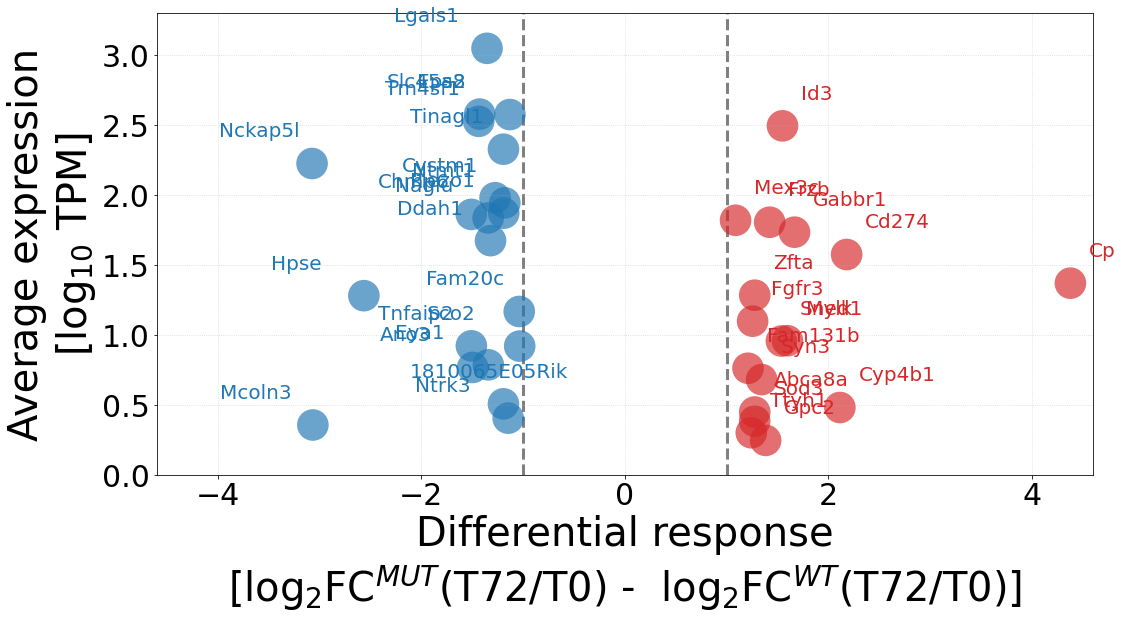

In [15]:
for i in range(len(strong_pattern_genes)):
    ensembl = strong_pattern_genes[i]
    
    gene_name = annotation.loc[ensembl]['ext_gene']
    locx = locations[ensembl][0]
    locy = locations[ensembl][1]
    
    if locx > 1:
        the_color = 'tab:red'
        matplotlib.pyplot.text(locx+(11/60), locy+(11.5/60), gene_name, color=the_color)
    elif locx < -1:
        the_color = 'tab:blue'
        matplotlib.pyplot.text(locx-(11/12), locy+(11.5/60), gene_name, color=the_color)
    else:
        print(locx)
        print('error')
        
    # finally plotting the dot
    matplotlib.pyplot.scatter(locx, locy, s=1000, c=the_color, alpha=2/3, edgecolor='none')
    
    # printing for interpretation
    if the_color == 'tab:blue':
        printing_color = 'blue'
    elif the_color == 'tab:red':
        printing_color = 'red'
    else:
        printing_color = 'grey'
    message = '\t'.join([gene_name, '{:.3f}'.format(locx), '{:.3f}'.format(locy), the_color])
    print(termcolor.colored(message, printing_color))

matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xlabel('Differential response\n[log$_2$FC$^{MUT}$(T72/T0) -  log$_2$FC$^{WT}$(T72/T0)]')
matplotlib.pyplot.ylabel('Average expression\n[log$_{10}$ TPM]')
matplotlib.pyplot.axvline(1, color='gray', ls='--', lw=3, zorder=0)
matplotlib.pyplot.axvline(-1, color='gray', ls='--', lw=3, zorder=0)
matplotlib.pyplot.xlim([-4.6, 4.6])
matplotlib.pyplot.ylim([0, 3.3])
matplotlib.pyplot.tight_layout()

## 5.1. scatter plot for weak pattern

Abca8a	1.277	0.448	tab:red
Tm4sf1	-1.436	2.524	tab:blue
Aif1l	-0.662	1.081	gray
Piezo1	-1.190	1.868	tab:blue
Pdlim2	0.564	0.804	gray
Fxyd1	0.977	1.153	gray
Ntmt1	-1.179	1.942	tab:blue
Tinagl1	-1.192	2.325	tab:blue
Plxna1	-0.870	2.149	gray
Nckap5l	-3.073	2.223	tab:blue
Frzb	1.424	1.803	tab:red
Id3	1.549	2.492	tab:red
Slc45a2	-1.426	2.576	tab:blue
Cd274	2.180	1.573	tab:red
Tnfaip2	-1.508	0.921	tab:blue
Sipa1l2	0.667	1.408	gray
Hpse	-2.564	1.279	tab:blue
Syn3	1.345	0.680	tab:red
Ano3	-1.495	0.766	tab:blue
Sod3	1.276	0.383	tab:red
Atp6v1g1	-0.916	2.643	gray
Fabp5	0.776	2.434	gray
Mknk2	-0.880	2.011	gray
Naglu	-1.343	1.834	tab:blue
Ddah1	-1.319	1.672	tab:blue
Mindy2	-0.747	1.737	gray
Sco2	-1.033	0.919	tab:blue
Gabbr1	1.668	1.732	tab:red
Tspan4	-0.966	2.330	gray
Ctsd	-0.623	3.193	gray
Atp6v0a1	-0.690	2.272	gray
Zfta	1.277	1.282	tab:red
Ntrk3	-1.146	0.404	tab:blue
Mcoln3	-3.065	0.355	tab:blue
Mylk	1.598	0.957	tab:red
Tox3	0.859	1.016	gray
Cyp4b1	2.113	0.480	tab:red
Gpc2	1.384	0.245	tab:red
Ag

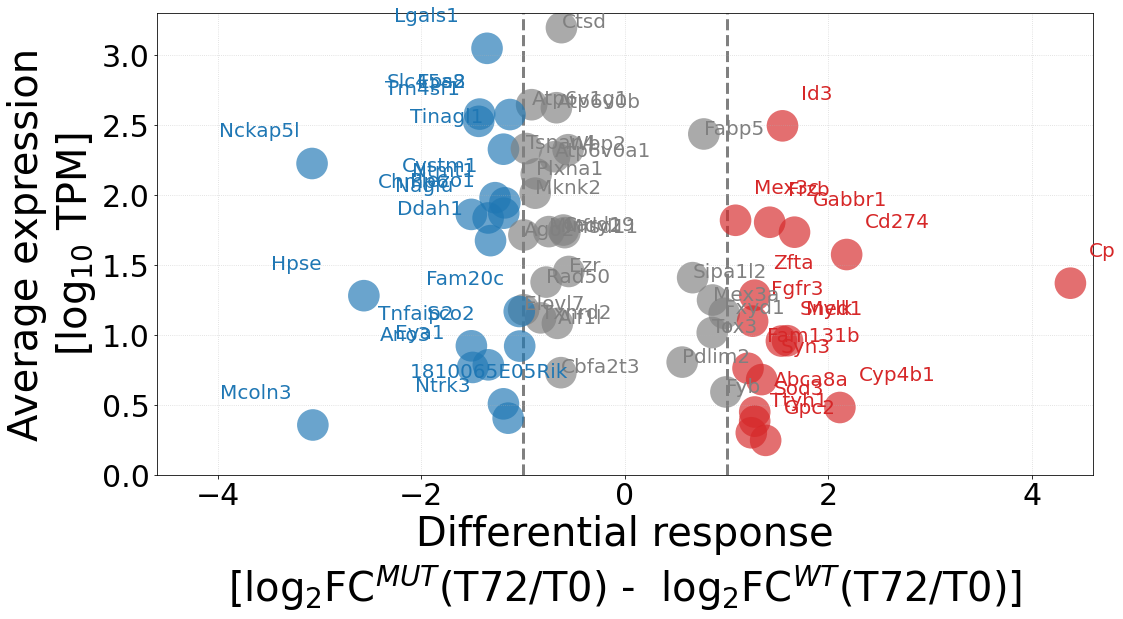

In [16]:
info = {}

for i in range(len(weak_pattern_genes)):
    ensembl = weak_pattern_genes[i]
    
    gene_name = annotation.loc[ensembl]['ext_gene']
    description = annotation.loc[ensembl]['description']
    locx = locations[ensembl][0]
    locy = locations[ensembl][1]
    info[ensembl] = [gene_name, description, locx, locy]
    
    if -1 < locx < 1:
        the_color = 'gray'
        matplotlib.pyplot.text(locx, locy, gene_name, color=the_color)
    elif locx > 1:
        the_color = 'tab:red'
        matplotlib.pyplot.text(locx+(11/60), locy+(11.5/60), gene_name, color=the_color)
    elif locx < -1:
        the_color = 'tab:blue'
        matplotlib.pyplot.text(locx-(11/12), locy+(11.5/60), gene_name, color=the_color)
    else:
        print(locx)
        print('error')
        
    # finally plotting the dot
    matplotlib.pyplot.scatter(locx, locy, s=1000, c=the_color, alpha=2/3, edgecolor='none')
    
    # printing for interpretation
    if the_color == 'tab:blue':
        printing_color = 'blue'
    elif the_color == 'tab:red':
        printing_color = 'red'
    else:
        printing_color = 'grey'
    message = '\t'.join([gene_name, '{:.3f}'.format(locx), '{:.3f}'.format(locy), the_color])
    print(termcolor.colored(message, printing_color))

matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xlabel('Differential response\n[log$_2$FC$^{MUT}$(T72/T0) -  log$_2$FC$^{WT}$(T72/T0)]')
matplotlib.pyplot.ylabel('Average expression\n[log$_{10}$ TPM]')
matplotlib.pyplot.axvline(1, color='gray', ls='--', lw=3, zorder=0)
matplotlib.pyplot.axvline(-1, color='gray', ls='--', lw=3, zorder=0)
matplotlib.pyplot.xlim([-4.6, 4.6])
matplotlib.pyplot.ylim([0, 3.3])
matplotlib.pyplot.tight_layout()

In [17]:
df = pandas.DataFrame.from_dict(info, orient='index', columns=['Gene name', 'Description', 'Response difference', 'Expression [log10 TPM]'])
df.sort_values(by='Response difference', inplace=True, ascending=False)

In [18]:
df[df['Response difference'] > 1]

,Gene name,Description,Response difference,Expression [log10 TPM]
ENSMUSG00000003617,Cp,ceruloplasmin [Source:MGI Symbol;Acc:MGI:88476],4.378652,1.368154
ENSMUSG00000016496,Cd274,CD274 antigen [Source:MGI Symbol;Acc:MGI:1926446],2.179817,1.572902
ENSMUSG00000028713,Cyp4b1,"cytochrome P450, family 4, subfamily b, polype...",2.113390,0.480160
ENSMUSG00000024462,Gabbr1,"gamma-aminobutyric acid (GABA) B receptor, 1 [...",1.667538,1.732430
ENSMUSG00000022836,Mylk,"myosin, light polypeptide kinase [Source:MGI S...",1.598179,0.957172
ENSMUSG00000007872,Id3,inhibitor of DNA binding 3 [Source:MGI Symbol;...,1.549490,2.492054
ENSMUSG00000047793,Sned1,"sushi, nidogen and EGF-like domains 1 [Source:...",1.538840,0.954916
ENSMUSG00000027004,Frzb,frizzled-related protein [Source:MGI Symbol;Ac...,1.423590,1.803436
ENSMUSG00000029510,Gpc2,glypican 2 (cerebroglycan) [Source:MGI Symbol;...,1.383874,0.245449
ENSMUSG00000059602,Syn3,synapsin III [Source:MGI Symbol;Acc:MGI:1351334],1.344674,0.679562


In [19]:
df[(df['Response difference'] < 1) & (df['Response difference'] > -1)]

,Gene name,Description,Response difference,Expression [log10 TPM]
ENSMUSG00000022148,Fyb,FYN binding protein [Source:MGI Symbol;Acc:MGI...,0.993686,0.591163
ENSMUSG00000036570,Fxyd1,FXYD domain-containing ion transport regulator...,0.976613,1.153035
ENSMUSG00000074480,Mex3a,mex3 RNA binding family member A [Source:MGI S...,0.862120,1.247971
ENSMUSG00000043668,Tox3,TOX high mobility group box family member 3 [S...,0.859260,1.015523
ENSMUSG00000027533,Fabp5,"fatty acid binding protein 5, epidermal [Sourc...",0.776444,2.433886
ENSMUSG00000001995,Sipa1l2,signal-induced proliferation-associated 1 like...,0.666552,1.407628
ENSMUSG00000022090,Pdlim2,PDZ and LIM domain 2 [Source:MGI Symbol;Acc:MG...,0.563798,0.804419
ENSMUSG00000052397,Ezr,ezrin [Source:MGI Symbol;Acc:MGI:98931],-0.550579,1.451815
ENSMUSG00000034341,Wbp2,WW domain binding protein 2 [Source:MGI Symbol...,-0.556863,2.321419
ENSMUSG00000020818,Mfsd11,major facilitator superfamily domain containin...,-0.589409,1.729116


# 6. identify enrichment

In [20]:
for ensembl in strong_pattern_genes:
    print(ensembl)

ENSMUSG00000041828
ENSMUSG00000027800
ENSMUSG00000014444
ENSMUSG00000026857
ENSMUSG00000028776
ENSMUSG00000023009
ENSMUSG00000027004
ENSMUSG00000007872
ENSMUSG00000022243
ENSMUSG00000016496
ENSMUSG00000021281
ENSMUSG00000035273
ENSMUSG00000059602
ENSMUSG00000074968
ENSMUSG00000072941
ENSMUSG00000001751
ENSMUSG00000028194
ENSMUSG00000091780
ENSMUSG00000024462
ENSMUSG00000053080
ENSMUSG00000059146
ENSMUSG00000036853
ENSMUSG00000022836
ENSMUSG00000028713
ENSMUSG00000029510
ENSMUSG00000054252
ENSMUSG00000068220
ENSMUSG00000003617
ENSMUSG00000025371
ENSMUSG00000046727
ENSMUSG00000030428
ENSMUSG00000015766
ENSMUSG00000047793
ENSMUSG00000025932
ENSMUSG00000029861
ENSMUSG00000037253
ENSMUSG00000025854
ENSMUSG00000013653


	Mus musculus (REF)	upload_1 ( Hierarchy  NEW! Tips)
Reactome pathways	#	#	expected	Fold Enrichment	+/-	P value
HS-GAG degradation	22	3	.04	85.70	+	1.37E-02
Unclassified	12955	12	20.61	.58	-	0.00E00


Naglu, Gpc2 and Hpse.

# 6. build heatmap

In [21]:
container = {}
for ensembl in strong_pattern_genes:
    full = numpy.concatenate((fitted_trajectory_mut[ensembl], fitted_trajectory_wt[ensembl]), axis=0)
    container[ensembl] = full
    
df = pandas.DataFrame.from_dict(container, orient='index', columns=['MUT_0h', 'MUT_48h', 'MUT_72h','WT_0h', 'WT_48h', 'WT_72h'])
df.head()

new_index = {}
for ensembl in df.index:
    gene_name = annotation.loc[ensembl]['ext_gene']
    new_index[ensembl] = gene_name
df.rename(index=new_index, inplace=True)

In [22]:
zscore_df = scipy.stats.zscore(df, axis=1)
zscore_df.head()

,MUT_0h,MUT_48h,MUT_72h,WT_0h,WT_48h,WT_72h
Abca8a,-0.544570,0.988365,1.754832,-0.878899,-0.703671,-0.616057
Tm4sf1,0.761890,-0.920091,-1.761082,0.258925,0.715929,0.944430
Piezo1,1.404301,-0.660610,-1.693066,0.819202,0.215910,-0.085736
Ntmt1,2.021654,-0.141243,-1.222691,0.169434,-0.296975,-0.530180
Tinagl1,1.982980,-0.263839,-1.387248,0.037781,-0.140313,-0.229360


In [23]:
print(numpy.max(zscore_df.max()))
print(numpy.min(zscore_df.min()))

top = 2.5; bottom = -2.5
top_white = 5/6; bottom_white = -5/6

2.079288560278588
-2.121559266991263


In [24]:
# edited from https://stackoverflow.com/questions/59270751/how-to-make-a-diverging-color-bar-with-white-space-between-two-values-matplotlib
p = [bottom, bottom_white, top_white, top]
f = lambda x: numpy.interp(x, p, [0, 0.5, 0.5, 1])
new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('map_white', list(zip(numpy.linspace(0,1), matplotlib.pyplot.cm.bwr(f(numpy.linspace(min(p), max(p)))))))

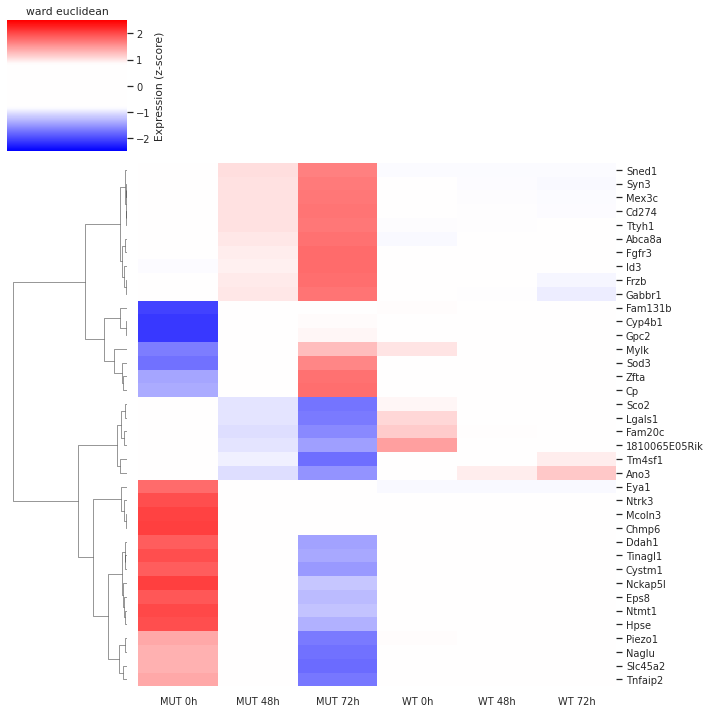

In [25]:
linkage_method = 'ward'
distance_metric = 'euclidean'
seaborn.set(font_scale=0.9)

h = seaborn.clustermap(zscore_df, cmap=new_cmap, col_cluster=False, vmin=bottom, vmax=top, method=linkage_method, metric=distance_metric, yticklabels=1, xticklabels = ['MUT 0h', 'MUT 48h', 'MUT 72h', 'WT 0h', 'WT 48h', 'WT 72h'], cbar_kws={'label':'Expression (z-score)'})

ordered_gene_names = [element.get_text() for element in h.ax_heatmap.get_yticklabels()]

matplotlib.pyplot.title('{} {}'.format(linkage_method, distance_metric))
matplotlib.pyplot.tight_layout()

matplotlib.pyplot.show()

#matplotlib.pyplot.savefig('heatmap.svg')

# 7.build dynamics

In [26]:
seaborn.reset_orig()
matplotlib.rcParams.update({'font.size':12, 'font.family':'sans-serif', 'xtick.labelsize':12, 'ytick.labelsize':12, 'figure.figsize':(16/2, 9/2), 'axes.labelsize':12})

In [27]:
strong_pattern_gene_names = [annotation.loc[ensembl]['ext_gene'] for ensembl in strong_pattern_genes]
strong_pattern_gene_names.sort()

['a3922_0h_1', 'a3922_0h_2', 'a3922_0h_3']
['a3922_48h_1', 'a3922_48h_2', 'a3922_48h_3']
['a3922_72h_1', 'a3922_72h_2', 'a3922_72h_3']
[0, 48, 72]
[10.33690012288791, 7.711686113450109, 6.9642614440880735]
['a4774_0h_1', 'a4774_0h_2', 'a4774_0h_3']
['a4774_48h_1', 'a4774_48h_2', 'a4774_48h_3']
['a4774_72h_1', 'a4774_72h_2']
[0, 48, 72]
[7.576552878807763, 1.6812820676552682, 1.893319524566945]
['a4775_0h_1', 'a4775_0h_2', 'a4775_0h_3']
['a4775_48h_1', 'a4775_48h_2', 'a4775_48h_3']
['a4775_72h_1', 'a4775_72h_2', 'a4775_72h_3']
[0, 48, 72]
[5.704409960582111, 1.9659031508746867, 2.0773180676056135]
['a4776_0h_1', 'a4776_0h_2', 'a4776_0h_3']
['a4776_48h_1', 'a4776_48h_2', 'a4776_48h_3']
['a4776_72h_1', 'a4776_72h_2', 'a4776_72h_3']
[0, 48, 72]
[5.155360047289933, 0.672333052354901, 0.6969846221095034]


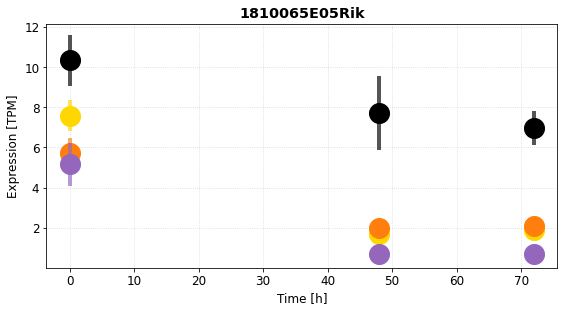

['a3922_0h_1', 'a3922_0h_2', 'a3922_0h_3']
['a3922_48h_1', 'a3922_48h_2', 'a3922_48h_3']
['a3922_72h_1', 'a3922_72h_2', 'a3922_72h_3']
[0, 48, 72]
[0.9515394002209657, 1.1480323034117534, 1.670639967076107]
['a4774_0h_1', 'a4774_0h_2', 'a4774_0h_3']
['a4774_48h_1', 'a4774_48h_2', 'a4774_48h_3']
['a4774_72h_1', 'a4774_72h_2']
[0, 48, 72]
[2.097843686538147, 7.7820368170186365, 12.0323484337911]
['a4775_0h_1', 'a4775_0h_2', 'a4775_0h_3']
['a4775_48h_1', 'a4775_48h_2', 'a4775_48h_3']
['a4775_72h_1', 'a4775_72h_2', 'a4775_72h_3']
[0, 48, 72]
[3.8345013946791333, 5.544012864326297, 9.869078125407393]
['a4776_0h_1', 'a4776_0h_2', 'a4776_0h_3']
['a4776_48h_1', 'a4776_48h_2', 'a4776_48h_3']
['a4776_72h_1', 'a4776_72h_2', 'a4776_72h_3']
[0, 48, 72]
[0.4197354693962074, 4.043391876282917, 5.690900694287953]


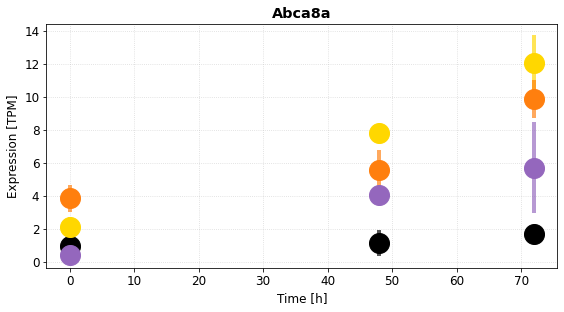

['a3922_0h_1', 'a3922_0h_2', 'a3922_0h_3']
['a3922_48h_1', 'a3922_48h_2', 'a3922_48h_3']
['a3922_72h_1', 'a3922_72h_2', 'a3922_72h_3']
[0, 48, 72]
[15.218495041003132, 18.00338201449583, 18.091557114368733]
['a4774_0h_1', 'a4774_0h_2', 'a4774_0h_3']
['a4774_48h_1', 'a4774_48h_2', 'a4774_48h_3']
['a4774_72h_1', 'a4774_72h_2']
[0, 48, 72]
[23.318191897355565, 13.030900294167635, 11.31176076384545]
['a4775_0h_1', 'a4775_0h_2', 'a4775_0h_3']
['a4775_48h_1', 'a4775_48h_2', 'a4775_48h_3']
['a4775_72h_1', 'a4775_72h_2', 'a4775_72h_3']
[0, 48, 72]
[12.463034227174367, 5.41342158762047, 4.772462052218409]
['a4776_0h_1', 'a4776_0h_2', 'a4776_0h_3']
['a4776_48h_1', 'a4776_48h_2', 'a4776_48h_3']
['a4776_72h_1', 'a4776_72h_2', 'a4776_72h_3']
[0, 48, 72]
[2.01799391024003, 0.4243846357014114, 0.47506976244891536]


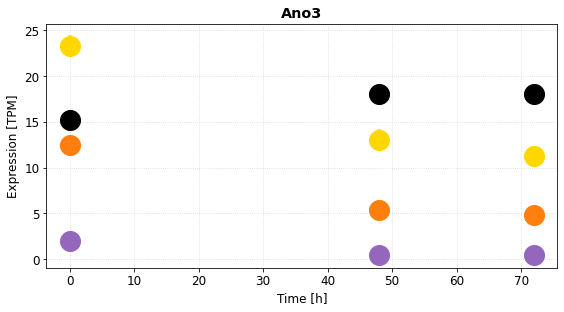

['a3922_0h_1', 'a3922_0h_2', 'a3922_0h_3']
['a3922_48h_1', 'a3922_48h_2', 'a3922_48h_3']
['a3922_72h_1', 'a3922_72h_2', 'a3922_72h_3']
[0, 48, 72]
[16.4171549891708, 13.220264962004466, 12.701441808667767]
['a4774_0h_1', 'a4774_0h_2', 'a4774_0h_3']
['a4774_48h_1', 'a4774_48h_2', 'a4774_48h_3']
['a4774_72h_1', 'a4774_72h_2']
[0, 48, 72]
[26.570905868703765, 83.52499847418204, 94.19636352117836]
['a4775_0h_1', 'a4775_0h_2', 'a4775_0h_3']
['a4775_48h_1', 'a4775_48h_2', 'a4775_48h_3']
['a4775_72h_1', 'a4775_72h_2', 'a4775_72h_3']
[0, 48, 72]
[14.4753202306525, 34.8299019368139, 47.310114661734]
['a4776_0h_1', 'a4776_0h_2', 'a4776_0h_3']
['a4776_48h_1', 'a4776_48h_2', 'a4776_48h_3']
['a4776_72h_1', 'a4776_72h_2', 'a4776_72h_3']
[0, 48, 72]
[33.180598602006405, 113.15703419055001, 138.02478474170266]


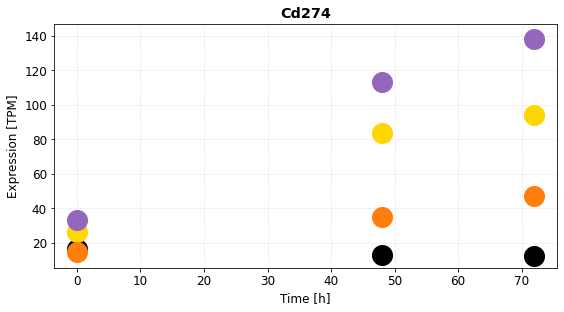

['a3922_0h_1', 'a3922_0h_2', 'a3922_0h_3']
['a3922_48h_1', 'a3922_48h_2', 'a3922_48h_3']
['a3922_72h_1', 'a3922_72h_2', 'a3922_72h_3']
[0, 48, 72]
[47.9595812178477, 50.941381065100565, 52.61667414575313]
['a4774_0h_1', 'a4774_0h_2', 'a4774_0h_3']
['a4774_48h_1', 'a4774_48h_2', 'a4774_48h_3']
['a4774_72h_1', 'a4774_72h_2']
[0, 48, 72]
[212.87636900961135, 105.07447724041587, 87.71304648653445]
['a4775_0h_1', 'a4775_0h_2', 'a4775_0h_3']
['a4775_48h_1', 'a4775_48h_2', 'a4775_48h_3']
['a4775_72h_1', 'a4775_72h_2', 'a4775_72h_3']
[0, 48, 72]
[193.18588518719068, 78.43507762091566, 77.772913116202]
['a4776_0h_1', 'a4776_0h_2', 'a4776_0h_3']
['a4776_48h_1', 'a4776_48h_2', 'a4776_48h_3']
['a4776_72h_1', 'a4776_72h_2', 'a4776_72h_3']
[0, 48, 72]
[46.04030496541867, 37.956320769600204, 38.480513355099504]


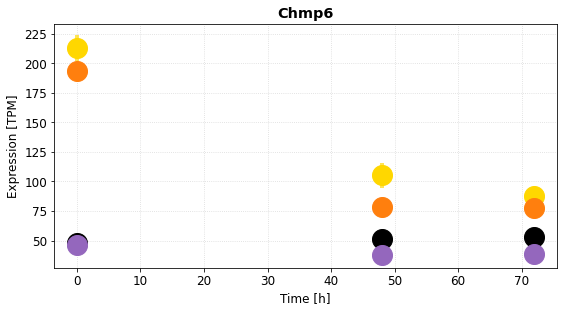

['a3922_0h_1', 'a3922_0h_2', 'a3922_0h_3']
['a3922_48h_1', 'a3922_48h_2', 'a3922_48h_3']
['a3922_72h_1', 'a3922_72h_2', 'a3922_72h_3']
[0, 48, 72]
[17.013227609428, 30.7801061867201, 25.86003370864097]
['a4774_0h_1', 'a4774_0h_2', 'a4774_0h_3']
['a4774_48h_1', 'a4774_48h_2', 'a4774_48h_3']
['a4774_72h_1', 'a4774_72h_2']
[0, 48, 72]
[8.0110950654964, 28.968514608781096, 53.1457483557045]
['a4775_0h_1', 'a4775_0h_2', 'a4775_0h_3']
['a4775_48h_1', 'a4775_48h_2', 'a4775_48h_3']
['a4775_72h_1', 'a4775_72h_2', 'a4775_72h_3']
[0, 48, 72]
[3.65843468879992, 26.29434082965787, 47.93076374803373]
['a4776_0h_1', 'a4776_0h_2', 'a4776_0h_3']
['a4776_48h_1', 'a4776_48h_2', 'a4776_48h_3']
['a4776_72h_1', 'a4776_72h_2', 'a4776_72h_3']
[0, 48, 72]
[5.798843999992488, 50.19033695230524, 136.88111489644166]


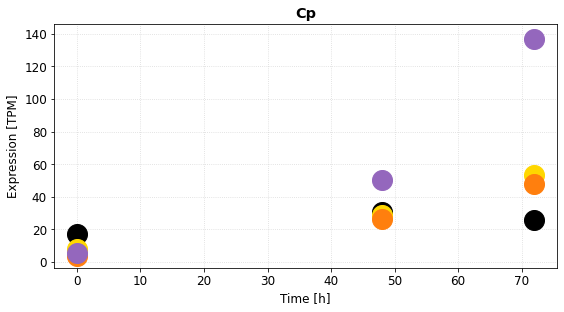

['a3922_0h_1', 'a3922_0h_2', 'a3922_0h_3']
['a3922_48h_1', 'a3922_48h_2', 'a3922_48h_3']
['a3922_72h_1', 'a3922_72h_2', 'a3922_72h_3']
[0, 48, 72]
[5.25179891448894, 4.987422044507963, 7.1245334282354404]
['a4774_0h_1', 'a4774_0h_2', 'a4774_0h_3']
['a4774_48h_1', 'a4774_48h_2', 'a4774_48h_3']
['a4774_72h_1', 'a4774_72h_2']
[0, 48, 72]
[0.7222351881361067, 2.7722030278701664, 4.491667911904075]
['a4775_0h_1', 'a4775_0h_2', 'a4775_0h_3']
['a4775_48h_1', 'a4775_48h_2', 'a4775_48h_3']
['a4775_72h_1', 'a4775_72h_2', 'a4775_72h_3']
[0, 48, 72]
[0.9615671983198698, 6.75464628046809, 9.935286348191184]
['a4776_0h_1', 'a4776_0h_2', 'a4776_0h_3']
['a4776_48h_1', 'a4776_48h_2', 'a4776_48h_3']
['a4776_72h_1', 'a4776_72h_2', 'a4776_72h_3']
[0, 48, 72]
[0.2679710971224867, 3.766819077481493, 6.248196280424939]


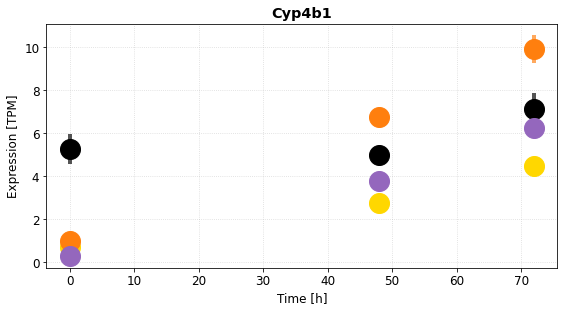

['a3922_0h_1', 'a3922_0h_2', 'a3922_0h_3']
['a3922_48h_1', 'a3922_48h_2', 'a3922_48h_3']
['a3922_72h_1', 'a3922_72h_2', 'a3922_72h_3']
[0, 48, 72]
[106.92422181074367, 98.46998272779513, 95.82926303364303]
['a4774_0h_1', 'a4774_0h_2', 'a4774_0h_3']
['a4774_48h_1', 'a4774_48h_2', 'a4774_48h_3']
['a4774_72h_1', 'a4774_72h_2']
[0, 48, 72]
[142.55540770618566, 87.40669305189964, 64.58473152747041]
['a4775_0h_1', 'a4775_0h_2', 'a4775_0h_3']
['a4775_48h_1', 'a4775_48h_2', 'a4775_48h_3']
['a4775_72h_1', 'a4775_72h_2', 'a4775_72h_3']
[0, 48, 72]
[156.94775312010566, 81.51399943647287, 55.69770430205843]
['a4776_0h_1', 'a4776_0h_2', 'a4776_0h_3']
['a4776_48h_1', 'a4776_48h_2', 'a4776_48h_3']
['a4776_72h_1', 'a4776_72h_2', 'a4776_72h_3']
[0, 48, 72]
[175.24229022982, 88.40677330866838, 61.816991988384764]


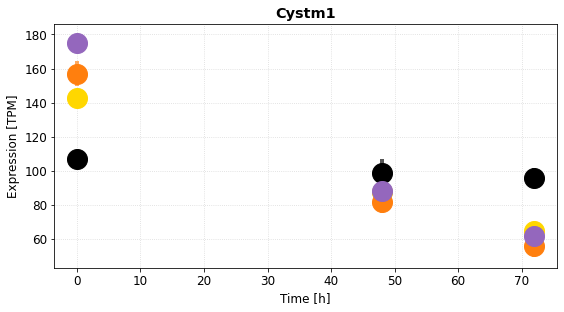

['a3922_0h_1', 'a3922_0h_2', 'a3922_0h_3']
['a3922_48h_1', 'a3922_48h_2', 'a3922_48h_3']
['a3922_72h_1', 'a3922_72h_2', 'a3922_72h_3']
[0, 48, 72]
[57.024123962748604, 48.998664901709596, 44.6069839762726]
['a4774_0h_1', 'a4774_0h_2', 'a4774_0h_3']
['a4774_48h_1', 'a4774_48h_2', 'a4774_48h_3']
['a4774_72h_1', 'a4774_72h_2']
[0, 48, 72]
[79.2817316928603, 38.598697359420974, 26.7391572293233]
['a4775_0h_1', 'a4775_0h_2', 'a4775_0h_3']
['a4775_48h_1', 'a4775_48h_2', 'a4775_48h_3']
['a4775_72h_1', 'a4775_72h_2', 'a4775_72h_3']
[0, 48, 72]
[88.59772443296357, 46.2618677013194, 35.794847353580664]
['a4776_0h_1', 'a4776_0h_2', 'a4776_0h_3']
['a4776_48h_1', 'a4776_48h_2', 'a4776_48h_3']
['a4776_72h_1', 'a4776_72h_2', 'a4776_72h_3']
[0, 48, 72]
[91.5701451739399, 35.1177117168678, 24.491520470785332]


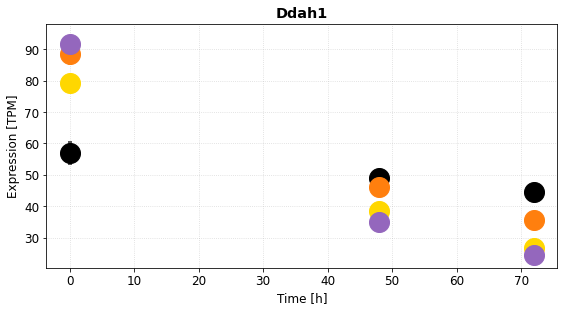

['a3922_0h_1', 'a3922_0h_2', 'a3922_0h_3']
['a3922_48h_1', 'a3922_48h_2', 'a3922_48h_3']
['a3922_72h_1', 'a3922_72h_2', 'a3922_72h_3']
[0, 48, 72]
[485.4628259957837, 321.78923638699735, 324.3760499080727]
['a4774_0h_1', 'a4774_0h_2', 'a4774_0h_3']
['a4774_48h_1', 'a4774_48h_2', 'a4774_48h_3']
['a4774_72h_1', 'a4774_72h_2']
[0, 48, 72]
[632.551692278288, 287.1477986056117, 278.89619296012]
['a4775_0h_1', 'a4775_0h_2', 'a4775_0h_3']
['a4775_48h_1', 'a4775_48h_2', 'a4775_48h_3']
['a4775_72h_1', 'a4775_72h_2', 'a4775_72h_3']
[0, 48, 72]
[795.0496119579224, 358.53527335734634, 326.8694930050323]
['a4776_0h_1', 'a4776_0h_2', 'a4776_0h_3']
['a4776_48h_1', 'a4776_48h_2', 'a4776_48h_3']
['a4776_72h_1', 'a4776_72h_2', 'a4776_72h_3']
[0, 48, 72]
[727.389628622169, 202.76845116112835, 201.76795028055065]


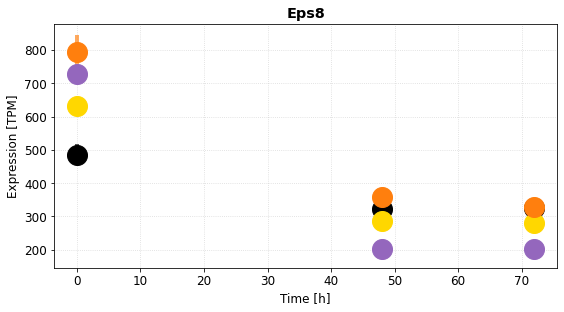

['a3922_0h_1', 'a3922_0h_2', 'a3922_0h_3']
['a3922_48h_1', 'a3922_48h_2', 'a3922_48h_3']
['a3922_72h_1', 'a3922_72h_2', 'a3922_72h_3']
[0, 48, 72]
[0.1620103197070437, 0.028407698994576097, 0.1305369882929731]
['a4774_0h_1', 'a4774_0h_2', 'a4774_0h_3']
['a4774_48h_1', 'a4774_48h_2', 'a4774_48h_3']
['a4774_72h_1', 'a4774_72h_2']
[0, 48, 72]
[43.870036126432005, 27.835396171483236, 22.141677376836498]
['a4775_0h_1', 'a4775_0h_2', 'a4775_0h_3']
['a4775_48h_1', 'a4775_48h_2', 'a4775_48h_3']
['a4775_72h_1', 'a4775_72h_2', 'a4775_72h_3']
[0, 48, 72]
[22.0794836339337, 8.26773630972545, 8.3236147453537]
['a4776_0h_1', 'a4776_0h_2', 'a4776_0h_3']
['a4776_48h_1', 'a4776_48h_2', 'a4776_48h_3']
['a4776_72h_1', 'a4776_72h_2', 'a4776_72h_3']
[0, 48, 72]
[91.05343584109987, 39.9767138409901, 36.747121760868396]


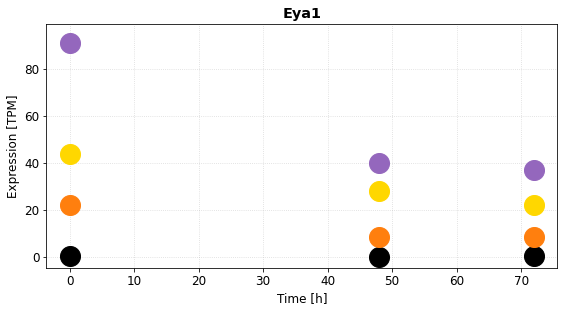

['a3922_0h_1', 'a3922_0h_2', 'a3922_0h_3']
['a3922_48h_1', 'a3922_48h_2', 'a3922_48h_3']
['a3922_72h_1', 'a3922_72h_2', 'a3922_72h_3']
[0, 48, 72]
[8.206955281195846, 8.594687060105175, 7.750122643956903]
['a4774_0h_1', 'a4774_0h_2', 'a4774_0h_3']
['a4774_48h_1', 'a4774_48h_2', 'a4774_48h_3']
['a4774_72h_1', 'a4774_72h_2']
[0, 48, 72]
[3.1366433340997233, 7.43009732053381, 7.915524161701569]
['a4775_0h_1', 'a4775_0h_2', 'a4775_0h_3']
['a4775_48h_1', 'a4775_48h_2', 'a4775_48h_3']
['a4775_72h_1', 'a4775_72h_2', 'a4775_72h_3']
[0, 48, 72]
[3.2626248475639863, 6.603446960184567, 7.88262241439611]
['a4776_0h_1', 'a4776_0h_2', 'a4776_0h_3']
['a4776_48h_1', 'a4776_48h_2', 'a4776_48h_3']
['a4776_72h_1', 'a4776_72h_2', 'a4776_72h_3']
[0, 48, 72]
[2.0477981252245834, 6.0733846091509776, 6.515537034751767]


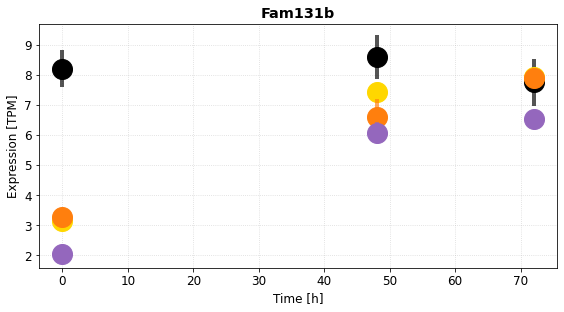

['a3922_0h_1', 'a3922_0h_2', 'a3922_0h_3']
['a3922_48h_1', 'a3922_48h_2', 'a3922_48h_3']
['a3922_72h_1', 'a3922_72h_2', 'a3922_72h_3']
[0, 48, 72]
[26.091763744575733, 24.2229649112442, 23.27836247200273]
['a4774_0h_1', 'a4774_0h_2', 'a4774_0h_3']
['a4774_48h_1', 'a4774_48h_2', 'a4774_48h_3']
['a4774_72h_1', 'a4774_72h_2']
[0, 48, 72]
[20.219701912745197, 11.6627590069714, 8.217659105871466]
['a4775_0h_1', 'a4775_0h_2', 'a4775_0h_3']
['a4775_48h_1', 'a4775_48h_2', 'a4775_48h_3']
['a4775_72h_1', 'a4775_72h_2', 'a4775_72h_3']
[0, 48, 72]
[20.391628090188203, 10.7162399032186, 9.020471894250889]
['a4776_0h_1', 'a4776_0h_2', 'a4776_0h_3']
['a4776_48h_1', 'a4776_48h_2', 'a4776_48h_3']
['a4776_72h_1', 'a4776_72h_2', 'a4776_72h_3']
[0, 48, 72]
[21.54965485184937, 10.104892761213202, 7.670445450381263]


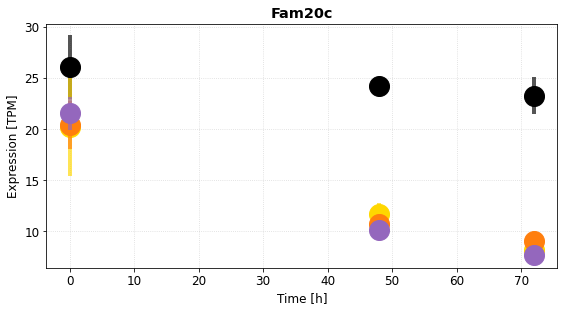

['a3922_0h_1', 'a3922_0h_2', 'a3922_0h_3']
['a3922_48h_1', 'a3922_48h_2', 'a3922_48h_3']
['a3922_72h_1', 'a3922_72h_2', 'a3922_72h_3']
[0, 48, 72]
[8.572511987607378, 8.360721376202479, 9.140011060216175]
['a4774_0h_1', 'a4774_0h_2', 'a4774_0h_3']
['a4774_48h_1', 'a4774_48h_2', 'a4774_48h_3']
['a4774_72h_1', 'a4774_72h_2']
[0, 48, 72]
[9.018240552463887, 27.4036598606049, 32.4306374377862]
['a4775_0h_1', 'a4775_0h_2', 'a4775_0h_3']
['a4775_48h_1', 'a4775_48h_2', 'a4775_48h_3']
['a4775_72h_1', 'a4775_72h_2', 'a4775_72h_3']
[0, 48, 72]
[8.492450660655033, 19.107068156017068, 14.334104611217834]
['a4776_0h_1', 'a4776_0h_2', 'a4776_0h_3']
['a4776_48h_1', 'a4776_48h_2', 'a4776_48h_3']
['a4776_72h_1', 'a4776_72h_2', 'a4776_72h_3']
[0, 48, 72]
[4.857305916485283, 13.2337798237185, 14.318860933328267]


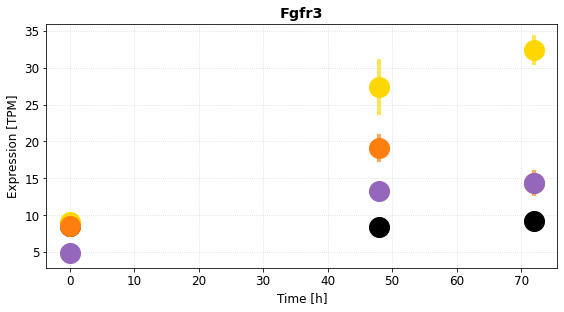

['a3922_0h_1', 'a3922_0h_2', 'a3922_0h_3']
['a3922_48h_1', 'a3922_48h_2', 'a3922_48h_3']
['a3922_72h_1', 'a3922_72h_2', 'a3922_72h_3']
[0, 48, 72]
[60.9713928897202, 46.25102753798087, 52.018884816410896]
['a4774_0h_1', 'a4774_0h_2', 'a4774_0h_3']
['a4774_48h_1', 'a4774_48h_2', 'a4774_48h_3']
['a4774_72h_1', 'a4774_72h_2']
[0, 48, 72]
[94.9761330386181, 133.31276107970768, 159.877875019337]
['a4775_0h_1', 'a4775_0h_2', 'a4775_0h_3']
['a4775_48h_1', 'a4775_48h_2', 'a4775_48h_3']
['a4775_72h_1', 'a4775_72h_2', 'a4775_72h_3']
[0, 48, 72]
[52.936532529098734, 144.95422803252234, 167.69457964627836]
['a4776_0h_1', 'a4776_0h_2', 'a4776_0h_3']
['a4776_48h_1', 'a4776_48h_2', 'a4776_48h_3']
['a4776_72h_1', 'a4776_72h_2', 'a4776_72h_3']
[0, 48, 72]
[17.047871911679497, 22.934319916861597, 30.0376463340517]


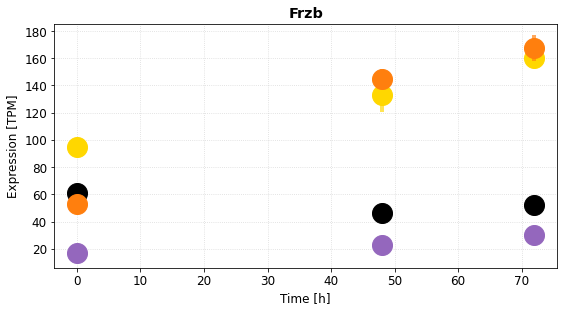

['a3922_0h_1', 'a3922_0h_2', 'a3922_0h_3']
['a3922_48h_1', 'a3922_48h_2', 'a3922_48h_3']
['a3922_72h_1', 'a3922_72h_2', 'a3922_72h_3']
[0, 48, 72]
[43.12095964067783, 25.46232041607563, 34.45554939744313]
['a4774_0h_1', 'a4774_0h_2', 'a4774_0h_3']
['a4774_48h_1', 'a4774_48h_2', 'a4774_48h_3']
['a4774_72h_1', 'a4774_72h_2']
[0, 48, 72]
[56.14909085669053, 81.41887569949387, 109.82826093702664]
['a4775_0h_1', 'a4775_0h_2', 'a4775_0h_3']
['a4775_48h_1', 'a4775_48h_2', 'a4775_48h_3']
['a4775_72h_1', 'a4775_72h_2', 'a4775_72h_3']
[0, 48, 72]
[34.520093390908265, 45.93055078770133, 60.19844307617114]
['a4776_0h_1', 'a4776_0h_2', 'a4776_0h_3']
['a4776_48h_1', 'a4776_48h_2', 'a4776_48h_3']
['a4776_72h_1', 'a4776_72h_2', 'a4776_72h_3']
[0, 48, 72]
[44.4016932853118, 78.55327510589872, 104.348613222925]


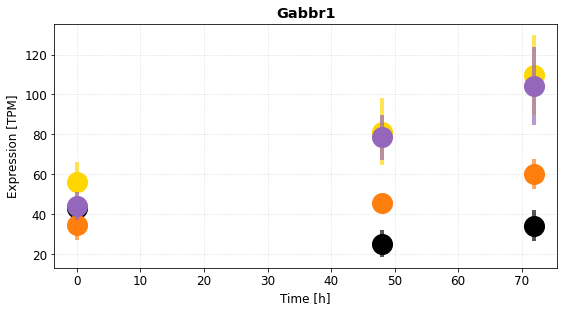

['a3922_0h_1', 'a3922_0h_2', 'a3922_0h_3']
['a3922_48h_1', 'a3922_48h_2', 'a3922_48h_3']
['a3922_72h_1', 'a3922_72h_2', 'a3922_72h_3']
[0, 48, 72]
[3.4636652443822133, 3.1149885521154297, 4.075054973833207]
['a4774_0h_1', 'a4774_0h_2', 'a4774_0h_3']
['a4774_48h_1', 'a4774_48h_2', 'a4774_48h_3']
['a4774_72h_1', 'a4774_72h_2']
[0, 48, 72]
[2.003504669542497, 4.5177337847494865, 8.20193084747935]
['a4775_0h_1', 'a4775_0h_2', 'a4775_0h_3']
['a4775_48h_1', 'a4775_48h_2', 'a4775_48h_3']
['a4775_72h_1', 'a4775_72h_2', 'a4775_72h_3']
[0, 48, 72]
[0.1444567691428989, 0.500722966369497, 0.6734584168473664]
['a4776_0h_1', 'a4776_0h_2', 'a4776_0h_3']
['a4776_48h_1', 'a4776_48h_2', 'a4776_48h_3']
['a4776_72h_1', 'a4776_72h_2', 'a4776_72h_3']
[0, 48, 72]
[0.49495209021602404, 3.723625531316943, 4.26227574529716]


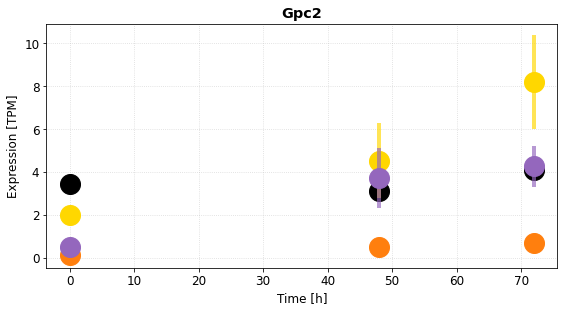

['a3922_0h_1', 'a3922_0h_2', 'a3922_0h_3']
['a3922_48h_1', 'a3922_48h_2', 'a3922_48h_3']
['a3922_72h_1', 'a3922_72h_2', 'a3922_72h_3']
[0, 48, 72]
[31.02580810741253, 21.752814398626267, 22.6377312955992]
['a4774_0h_1', 'a4774_0h_2', 'a4774_0h_3']
['a4774_48h_1', 'a4774_48h_2', 'a4774_48h_3']
['a4774_72h_1', 'a4774_72h_2']
[0, 48, 72]
[60.790736821764966, 21.303839842396567, 15.29816320570595]
['a4775_0h_1', 'a4775_0h_2', 'a4775_0h_3']
['a4775_48h_1', 'a4775_48h_2', 'a4775_48h_3']
['a4775_72h_1', 'a4775_72h_2', 'a4775_72h_3']
[0, 48, 72]
[14.550222155786466, 4.111837508550294, 3.2468728666842566]
['a4776_0h_1', 'a4776_0h_2', 'a4776_0h_3']
['a4776_48h_1', 'a4776_48h_2', 'a4776_48h_3']
['a4776_72h_1', 'a4776_72h_2', 'a4776_72h_3']
[0, 48, 72]
[110.01199997203832, 23.888574731094298, 15.0938454089034]


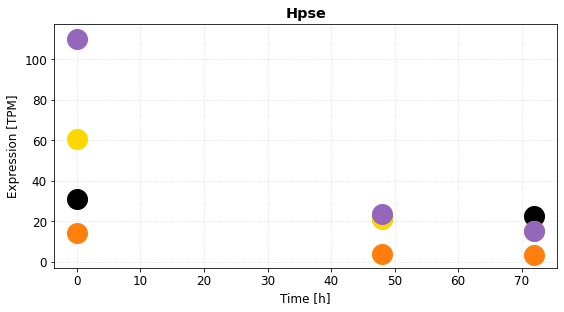

['a3922_0h_1', 'a3922_0h_2', 'a3922_0h_3']
['a3922_48h_1', 'a3922_48h_2', 'a3922_48h_3']
['a3922_72h_1', 'a3922_72h_2', 'a3922_72h_3']
[0, 48, 72]
[266.69464672497566, 229.40827015583864, 213.59937012375]
['a4774_0h_1', 'a4774_0h_2', 'a4774_0h_3']
['a4774_48h_1', 'a4774_48h_2', 'a4774_48h_3']
['a4774_72h_1', 'a4774_72h_2']
[0, 48, 72]
[172.467727075493, 521.1166545684406, 550.3815653696324]
['a4775_0h_1', 'a4775_0h_2', 'a4775_0h_3']
['a4775_48h_1', 'a4775_48h_2', 'a4775_48h_3']
['a4775_72h_1', 'a4775_72h_2', 'a4775_72h_3']
[0, 48, 72]
[245.26646772821834, 431.58183030493336, 417.76448777146]
['a4776_0h_1', 'a4776_0h_2', 'a4776_0h_3']
['a4776_48h_1', 'a4776_48h_2', 'a4776_48h_3']
['a4776_72h_1', 'a4776_72h_2', 'a4776_72h_3']
[0, 48, 72]
[131.23862264805868, 472.831809384261, 431.10616775841635]


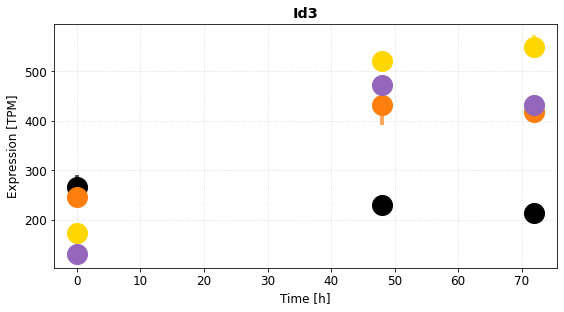

['a3922_0h_1', 'a3922_0h_2', 'a3922_0h_3']
['a3922_48h_1', 'a3922_48h_2', 'a3922_48h_3']
['a3922_72h_1', 'a3922_72h_2', 'a3922_72h_3']
[0, 48, 72]
[1996.0484454905934, 1822.2019748732, 1777.1110268250268]
['a4774_0h_1', 'a4774_0h_2', 'a4774_0h_3']
['a4774_48h_1', 'a4774_48h_2', 'a4774_48h_3']
['a4774_72h_1', 'a4774_72h_2']
[0, 48, 72]
[1291.8510222430034, 694.0265581327731, 565.6052916617016]
['a4775_0h_1', 'a4775_0h_2', 'a4775_0h_3']
['a4775_48h_1', 'a4775_48h_2', 'a4775_48h_3']
['a4775_72h_1', 'a4775_72h_2', 'a4775_72h_3']
[0, 48, 72]
[2392.5179424189964, 1066.0456479916932, 826.0155500285728]
['a4776_0h_1', 'a4776_0h_2', 'a4776_0h_3']
['a4776_48h_1', 'a4776_48h_2', 'a4776_48h_3']
['a4776_72h_1', 'a4776_72h_2', 'a4776_72h_3']
[0, 48, 72]
[1486.7870102907766, 670.063673391334, 514.598211670199]


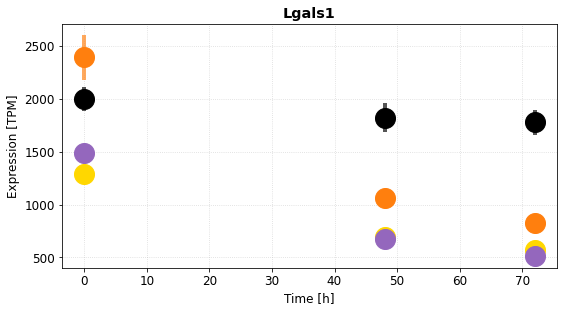

['a3922_0h_1', 'a3922_0h_2', 'a3922_0h_3']
['a3922_48h_1', 'a3922_48h_2', 'a3922_48h_3']
['a3922_72h_1', 'a3922_72h_2', 'a3922_72h_3']
[0, 48, 72]
[0.08622386332906318, 0.015509477859972268, 0.0909882834938356]
['a4774_0h_1', 'a4774_0h_2', 'a4774_0h_3']
['a4774_48h_1', 'a4774_48h_2', 'a4774_48h_3']
['a4774_72h_1', 'a4774_72h_2']
[0, 48, 72]
[13.652386678366733, 5.8394933059128205, 3.0261889836767653]
['a4775_0h_1', 'a4775_0h_2', 'a4775_0h_3']
['a4775_48h_1', 'a4775_48h_2', 'a4775_48h_3']
['a4775_72h_1', 'a4775_72h_2', 'a4775_72h_3']
[0, 48, 72]
[184.33799442108867, 45.97929012708314, 30.589265321216562]
['a4776_0h_1', 'a4776_0h_2', 'a4776_0h_3']
['a4776_48h_1', 'a4776_48h_2', 'a4776_48h_3']
['a4776_72h_1', 'a4776_72h_2', 'a4776_72h_3']
[0, 48, 72]
[4.344606358717127, 1.4754783778064973, 1.6161008559385295]


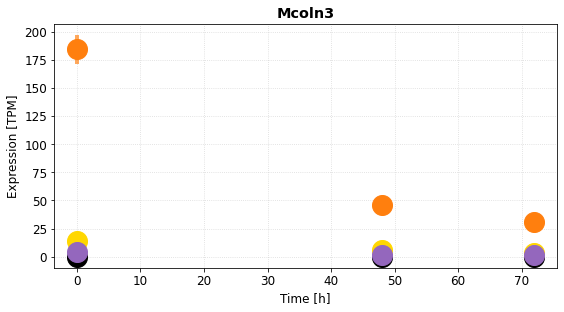

['a3922_0h_1', 'a3922_0h_2', 'a3922_0h_3']
['a3922_48h_1', 'a3922_48h_2', 'a3922_48h_3']
['a3922_72h_1', 'a3922_72h_2', 'a3922_72h_3']
[0, 48, 72]
[40.95851915272793, 38.746977629802664, 38.769460458506764]
['a4774_0h_1', 'a4774_0h_2', 'a4774_0h_3']
['a4774_48h_1', 'a4774_48h_2', 'a4774_48h_3']
['a4774_72h_1', 'a4774_72h_2']
[0, 48, 72]
[49.5779695641584, 88.69126728631011, 94.08797333085025]
['a4775_0h_1', 'a4775_0h_2', 'a4775_0h_3']
['a4775_48h_1', 'a4775_48h_2', 'a4775_48h_3']
['a4775_72h_1', 'a4775_72h_2', 'a4775_72h_3']
[0, 48, 72]
[51.239786915798, 75.27798833411327, 93.1703618786765]
['a4776_0h_1', 'a4776_0h_2', 'a4776_0h_3']
['a4776_48h_1', 'a4776_48h_2', 'a4776_48h_3']
['a4776_72h_1', 'a4776_72h_2', 'a4776_72h_3']
[0, 48, 72]
[50.32782040095563, 112.56767649785866, 121.73164902092401]


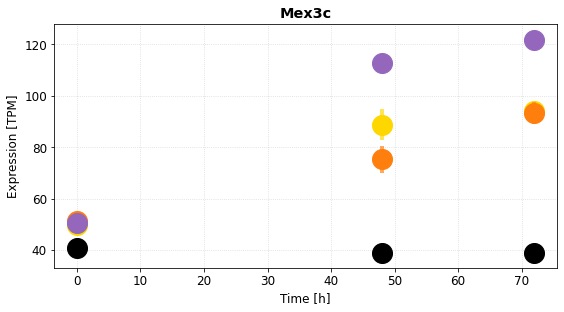

['a3922_0h_1', 'a3922_0h_2', 'a3922_0h_3']
['a3922_48h_1', 'a3922_48h_2', 'a3922_48h_3']
['a3922_72h_1', 'a3922_72h_2', 'a3922_72h_3']
[0, 48, 72]
[13.365916155366099, 8.16223091284582, 9.125522381832633]
['a4774_0h_1', 'a4774_0h_2', 'a4774_0h_3']
['a4774_48h_1', 'a4774_48h_2', 'a4774_48h_3']
['a4774_72h_1', 'a4774_72h_2']
[0, 48, 72]
[6.768684024549437, 9.311412609633598, 11.019289487679096]
['a4775_0h_1', 'a4775_0h_2', 'a4775_0h_3']
['a4775_48h_1', 'a4775_48h_2', 'a4775_48h_3']
['a4775_72h_1', 'a4775_72h_2', 'a4775_72h_3']
[0, 48, 72]
[4.313276301551974, 5.273131419779833, 6.294729594004447]
['a4776_0h_1', 'a4776_0h_2', 'a4776_0h_3']
['a4776_48h_1', 'a4776_48h_2', 'a4776_48h_3']
['a4776_72h_1', 'a4776_72h_2', 'a4776_72h_3']
[0, 48, 72]
[8.495061260078964, 17.888195363255, 23.780501872317867]


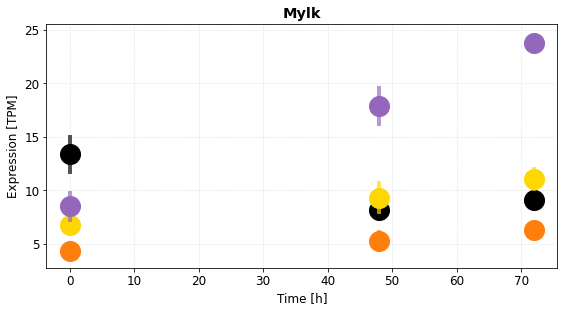

['a3922_0h_1', 'a3922_0h_2', 'a3922_0h_3']
['a3922_48h_1', 'a3922_48h_2', 'a3922_48h_3']
['a3922_72h_1', 'a3922_72h_2', 'a3922_72h_3']
[0, 48, 72]
[96.96966982014607, 83.2207645021586, 82.99312102991179]
['a4774_0h_1', 'a4774_0h_2', 'a4774_0h_3']
['a4774_48h_1', 'a4774_48h_2', 'a4774_48h_3']
['a4774_72h_1', 'a4774_72h_2']
[0, 48, 72]
[90.5410506774619, 49.574418199527535, 37.7373351076791]
['a4775_0h_1', 'a4775_0h_2', 'a4775_0h_3']
['a4775_48h_1', 'a4775_48h_2', 'a4775_48h_3']
['a4775_72h_1', 'a4775_72h_2', 'a4775_72h_3']
[0, 48, 72]
[131.897581340363, 58.158585540022806, 47.44396150344977]
['a4776_0h_1', 'a4776_0h_2', 'a4776_0h_3']
['a4776_48h_1', 'a4776_48h_2', 'a4776_48h_3']
['a4776_72h_1', 'a4776_72h_2', 'a4776_72h_3']
[0, 48, 72]
[119.13235337025333, 51.31433977360763, 39.595284950250864]


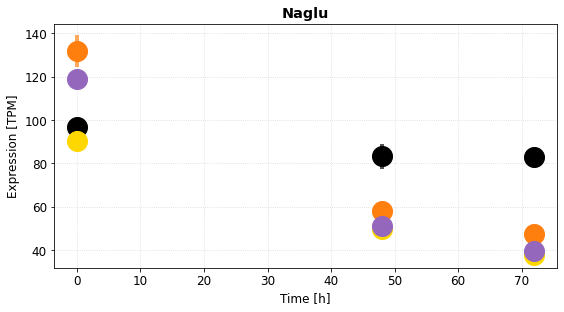

['a3922_0h_1', 'a3922_0h_2', 'a3922_0h_3']
['a3922_48h_1', 'a3922_48h_2', 'a3922_48h_3']
['a3922_72h_1', 'a3922_72h_2', 'a3922_72h_3']
[0, 48, 72]
[186.54505349124233, 150.19289943734202, 156.97669177167467]
['a4774_0h_1', 'a4774_0h_2', 'a4774_0h_3']
['a4774_48h_1', 'a4774_48h_2', 'a4774_48h_3']
['a4774_72h_1', 'a4774_72h_2']
[0, 48, 72]
[254.43465603801334, 122.020625664604, 89.591658804864]
['a4775_0h_1', 'a4775_0h_2', 'a4775_0h_3']
['a4775_48h_1', 'a4775_48h_2', 'a4775_48h_3']
['a4775_72h_1', 'a4775_72h_2', 'a4775_72h_3']
[0, 48, 72]
[470.4600186060443, 117.49178478379633, 92.79330851947945]
['a4776_0h_1', 'a4776_0h_2', 'a4776_0h_3']
['a4776_48h_1', 'a4776_48h_2', 'a4776_48h_3']
['a4776_72h_1', 'a4776_72h_2', 'a4776_72h_3']
[0, 48, 72]
[725.887657179206, 132.59472410109933, 79.7805777701297]


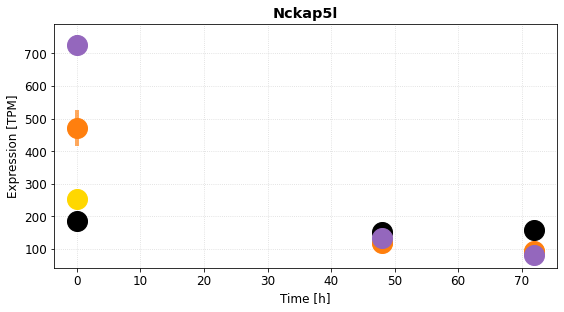

['a3922_0h_1', 'a3922_0h_2', 'a3922_0h_3']
['a3922_48h_1', 'a3922_48h_2', 'a3922_48h_3']
['a3922_72h_1', 'a3922_72h_2', 'a3922_72h_3']
[0, 48, 72]
[97.56974768054754, 79.65017134922994, 76.82067825453758]
['a4774_0h_1', 'a4774_0h_2', 'a4774_0h_3']
['a4774_48h_1', 'a4774_48h_2', 'a4774_48h_3']
['a4774_72h_1', 'a4774_72h_2']
[0, 48, 72]
[165.058176276092, 75.19053911195687, 68.1623201955066]
['a4775_0h_1', 'a4775_0h_2', 'a4775_0h_3']
['a4775_48h_1', 'a4775_48h_2', 'a4775_48h_3']
['a4775_72h_1', 'a4775_72h_2', 'a4775_72h_3']
[0, 48, 72]
[163.987054641742, 68.18913040170052, 64.98215267124986]
['a4776_0h_1', 'a4776_0h_2', 'a4776_0h_3']
['a4776_48h_1', 'a4776_48h_2', 'a4776_48h_3']
['a4776_72h_1', 'a4776_72h_2', 'a4776_72h_3']
[0, 48, 72]
[162.34893780638, 64.79671170137006, 57.5094628197036]


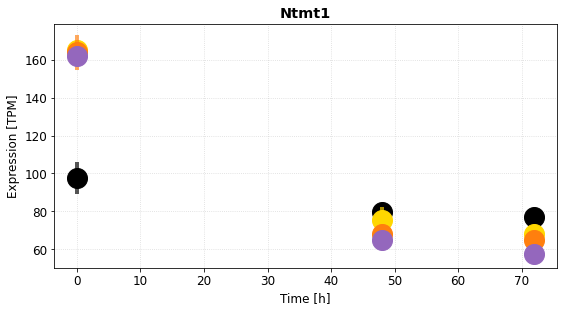

['a3922_0h_1', 'a3922_0h_2', 'a3922_0h_3']
['a3922_48h_1', 'a3922_48h_2', 'a3922_48h_3']
['a3922_72h_1', 'a3922_72h_2', 'a3922_72h_3']
[0, 48, 72]
[1.1011755352931252, 1.3096545949181848, 0.9777367998190897]
['a4774_0h_1', 'a4774_0h_2', 'a4774_0h_3']
['a4774_48h_1', 'a4774_48h_2', 'a4774_48h_3']
['a4774_72h_1', 'a4774_72h_2']
[0, 48, 72]
[7.879529481185372, 3.8099231066311265, 2.832374437574]
['a4775_0h_1', 'a4775_0h_2', 'a4775_0h_3']
['a4775_48h_1', 'a4775_48h_2', 'a4775_48h_3']
['a4775_72h_1', 'a4775_72h_2', 'a4775_72h_3']
[0, 48, 72]
[8.663631225125927, 3.3550682046500704, 2.988550492920393]
['a4776_0h_1', 'a4776_0h_2', 'a4776_0h_3']
['a4776_48h_1', 'a4776_48h_2', 'a4776_48h_3']
['a4776_72h_1', 'a4776_72h_2', 'a4776_72h_3']
[0, 48, 72]
[2.63681338175081, 1.7145912908966068, 1.5535246585333773]


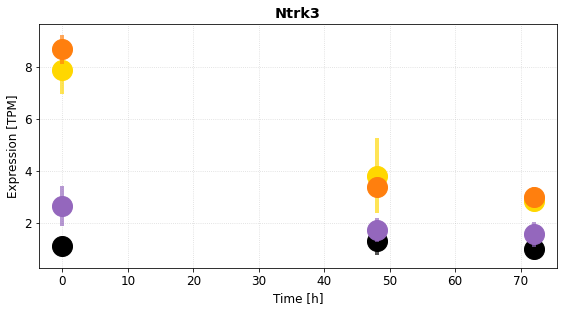

['a3922_0h_1', 'a3922_0h_2', 'a3922_0h_3']
['a3922_48h_1', 'a3922_48h_2', 'a3922_48h_3']
['a3922_72h_1', 'a3922_72h_2', 'a3922_72h_3']
[0, 48, 72]
[102.65104426601796, 85.03033504631327, 83.12161476539316]
['a4774_0h_1', 'a4774_0h_2', 'a4774_0h_3']
['a4774_48h_1', 'a4774_48h_2', 'a4774_48h_3']
['a4774_72h_1', 'a4774_72h_2']
[0, 48, 72]
[122.10813752153267, 63.644151857693096, 53.66563921675295]
['a4775_0h_1', 'a4775_0h_2', 'a4775_0h_3']
['a4775_48h_1', 'a4775_48h_2', 'a4775_48h_3']
['a4775_72h_1', 'a4775_72h_2', 'a4775_72h_3']
[0, 48, 72]
[127.14919817245868, 62.16055349837817, 52.469217469748365]
['a4776_0h_1', 'a4776_0h_2', 'a4776_0h_3']
['a4776_48h_1', 'a4776_48h_2', 'a4776_48h_3']
['a4776_72h_1', 'a4776_72h_2', 'a4776_72h_3']
[0, 48, 72]
[120.26880565631933, 44.754288854847935, 38.50040799983513]


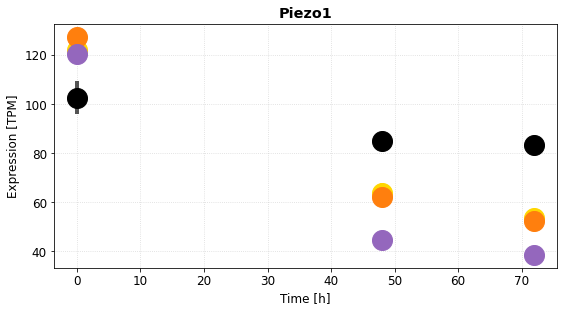

['a3922_0h_1', 'a3922_0h_2', 'a3922_0h_3']
['a3922_48h_1', 'a3922_48h_2', 'a3922_48h_3']
['a3922_72h_1', 'a3922_72h_2', 'a3922_72h_3']
[0, 48, 72]
[13.132599541935301, 13.389504061341668, 12.8044923796239]
['a4774_0h_1', 'a4774_0h_2', 'a4774_0h_3']
['a4774_48h_1', 'a4774_48h_2', 'a4774_48h_3']
['a4774_72h_1', 'a4774_72h_2']
[0, 48, 72]
[12.564469343540138, 5.703678418898473, 5.57351649884745]
['a4775_0h_1', 'a4775_0h_2', 'a4775_0h_3']
['a4775_48h_1', 'a4775_48h_2', 'a4775_48h_3']
['a4775_72h_1', 'a4775_72h_2', 'a4775_72h_3']
[0, 48, 72]
[12.022500832068834, 8.265219765162419, 8.900054494972045]
['a4776_0h_1', 'a4776_0h_2', 'a4776_0h_3']
['a4776_48h_1', 'a4776_48h_2', 'a4776_48h_3']
['a4776_72h_1', 'a4776_72h_2', 'a4776_72h_3']
[0, 48, 72]
[11.59843165807433, 3.25877221197319, 4.445003937096883]


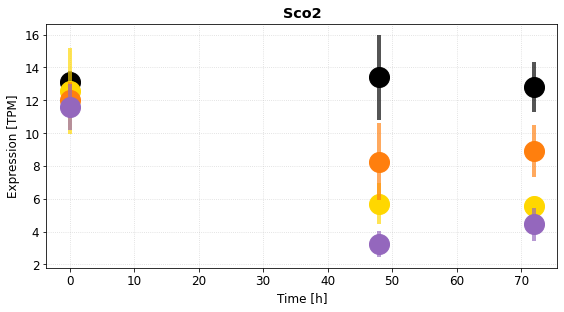

['a3922_0h_1', 'a3922_0h_2', 'a3922_0h_3']
['a3922_48h_1', 'a3922_48h_2', 'a3922_48h_3']
['a3922_72h_1', 'a3922_72h_2', 'a3922_72h_3']
[0, 48, 72]
[467.56732823575436, 474.091713780435, 463.652577493996]
['a4774_0h_1', 'a4774_0h_2', 'a4774_0h_3']
['a4774_48h_1', 'a4774_48h_2', 'a4774_48h_3']
['a4774_72h_1', 'a4774_72h_2']
[0, 48, 72]
[467.2872476726643, 256.07693404030164, 212.1686072852845]
['a4775_0h_1', 'a4775_0h_2', 'a4775_0h_3']
['a4775_48h_1', 'a4775_48h_2', 'a4775_48h_3']
['a4775_72h_1', 'a4775_72h_2', 'a4775_72h_3']
[0, 48, 72]
[633.4559581488926, 355.1578282290787, 311.93005494837263]
['a4776_0h_1', 'a4776_0h_2', 'a4776_0h_3']
['a4776_48h_1', 'a4776_48h_2', 'a4776_48h_3']
['a4776_72h_1', 'a4776_72h_2', 'a4776_72h_3']
[0, 48, 72]
[677.6716886421093, 267.7357617716457, 223.590500726883]


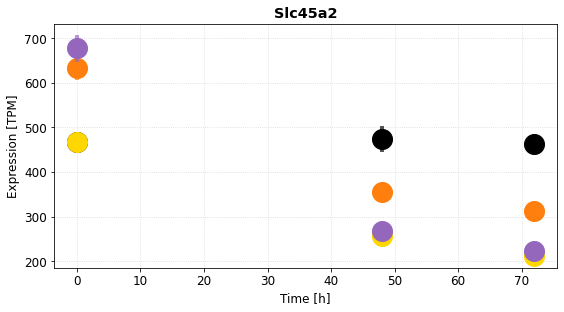

['a3922_0h_1', 'a3922_0h_2', 'a3922_0h_3']
['a3922_48h_1', 'a3922_48h_2', 'a3922_48h_3']
['a3922_72h_1', 'a3922_72h_2', 'a3922_72h_3']
[0, 48, 72]
[1.6907214904644265, 1.160911172490095, 1.6966302296260765]
['a4774_0h_1', 'a4774_0h_2', 'a4774_0h_3']
['a4774_48h_1', 'a4774_48h_2', 'a4774_48h_3']
['a4774_72h_1', 'a4774_72h_2']
[0, 48, 72]
[12.242127800758935, 21.756323250544934, 31.5651622616377]
['a4775_0h_1', 'a4775_0h_2', 'a4775_0h_3']
['a4775_48h_1', 'a4775_48h_2', 'a4775_48h_3']
['a4775_72h_1', 'a4775_72h_2', 'a4775_72h_3']
[0, 48, 72]
[6.940092673632719, 11.97767806080791, 17.496928915614667]
['a4776_0h_1', 'a4776_0h_2', 'a4776_0h_3']
['a4776_48h_1', 'a4776_48h_2', 'a4776_48h_3']
['a4776_72h_1', 'a4776_72h_2', 'a4776_72h_3']
[0, 48, 72]
[7.7973661922697275, 26.506257372781835, 36.06371883583963]


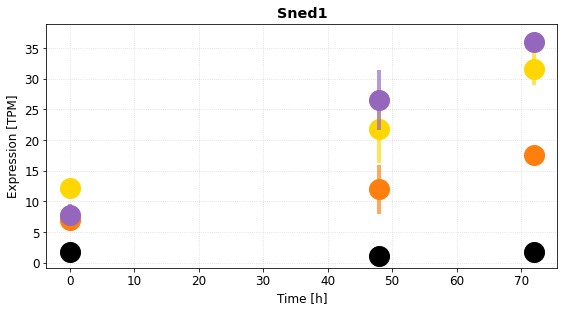

['a3922_0h_1', 'a3922_0h_2', 'a3922_0h_3']
['a3922_48h_1', 'a3922_48h_2', 'a3922_48h_3']
['a3922_72h_1', 'a3922_72h_2', 'a3922_72h_3']
[0, 48, 72]
[4.200104460146551, 3.6374208768126066, 4.651259794639453]
['a4774_0h_1', 'a4774_0h_2', 'a4774_0h_3']
['a4774_48h_1', 'a4774_48h_2', 'a4774_48h_3']
['a4774_72h_1', 'a4774_72h_2']
[0, 48, 72]
[1.39096519812027, 2.2428913093634804, 3.3288043479038496]
['a4775_0h_1', 'a4775_0h_2', 'a4775_0h_3']
['a4775_48h_1', 'a4775_48h_2', 'a4775_48h_3']
['a4775_72h_1', 'a4775_72h_2', 'a4775_72h_3']
[0, 48, 72]
[3.52626322032584, 12.856991168438215, 14.456872410146866]
['a4776_0h_1', 'a4776_0h_2', 'a4776_0h_3']
['a4776_48h_1', 'a4776_48h_2', 'a4776_48h_3']
['a4776_72h_1', 'a4776_72h_2', 'a4776_72h_3']
[0, 48, 72]
[0.21216359772726734, 0.5535591920653634, 0.9014594354832403]


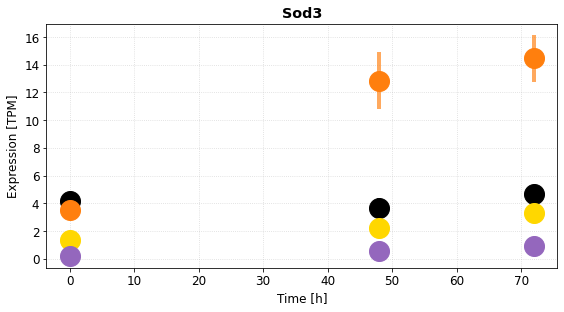

['a3922_0h_1', 'a3922_0h_2', 'a3922_0h_3']
['a3922_48h_1', 'a3922_48h_2', 'a3922_48h_3']
['a3922_72h_1', 'a3922_72h_2', 'a3922_72h_3']
[0, 48, 72]
[2.3619430452125134, 1.9466804836454734, 2.4625517866248896]
['a4774_0h_1', 'a4774_0h_2', 'a4774_0h_3']
['a4774_48h_1', 'a4774_48h_2', 'a4774_48h_3']
['a4774_72h_1', 'a4774_72h_2']
[0, 48, 72]
[5.938597712609777, 8.190272422370928, 11.347350421032]
['a4775_0h_1', 'a4775_0h_2', 'a4775_0h_3']
['a4775_48h_1', 'a4775_48h_2', 'a4775_48h_3']
['a4775_72h_1', 'a4775_72h_2', 'a4775_72h_3']
[0, 48, 72]
[1.9659213019907031, 7.023059591908061, 5.84710952318449]
['a4776_0h_1', 'a4776_0h_2', 'a4776_0h_3']
['a4776_48h_1', 'a4776_48h_2', 'a4776_48h_3']
['a4776_72h_1', 'a4776_72h_2', 'a4776_72h_3']
[0, 48, 72]
[3.0318006035387337, 9.561983303837229, 11.471431399455676]


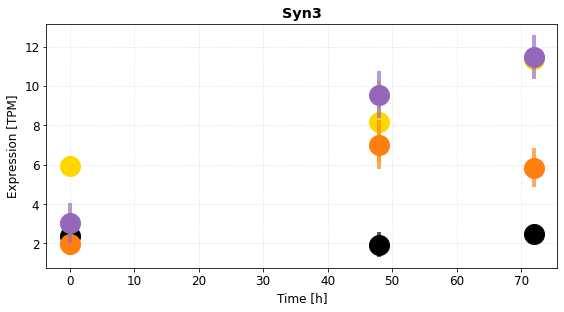

['a3922_0h_1', 'a3922_0h_2', 'a3922_0h_3']
['a3922_48h_1', 'a3922_48h_2', 'a3922_48h_3']
['a3922_72h_1', 'a3922_72h_2', 'a3922_72h_3']
[0, 48, 72]
[233.20307066310167, 200.98063528445002, 224.56084722250299]
['a4774_0h_1', 'a4774_0h_2', 'a4774_0h_3']
['a4774_48h_1', 'a4774_48h_2', 'a4774_48h_3']
['a4774_72h_1', 'a4774_72h_2']
[0, 48, 72]
[392.3964016498906, 196.43242192866765, 200.01313846544952]
['a4775_0h_1', 'a4775_0h_2', 'a4775_0h_3']
['a4775_48h_1', 'a4775_48h_2', 'a4775_48h_3']
['a4775_72h_1', 'a4775_72h_2', 'a4775_72h_3']
[0, 48, 72]
[249.64940495243602, 121.66584670639934, 117.35130129778001]
['a4776_0h_1', 'a4776_0h_2', 'a4776_0h_3']
['a4776_48h_1', 'a4776_48h_2', 'a4776_48h_3']
['a4776_72h_1', 'a4776_72h_2', 'a4776_72h_3']
[0, 48, 72]
[428.284487415102, 197.28299262835165, 183.966300628124]


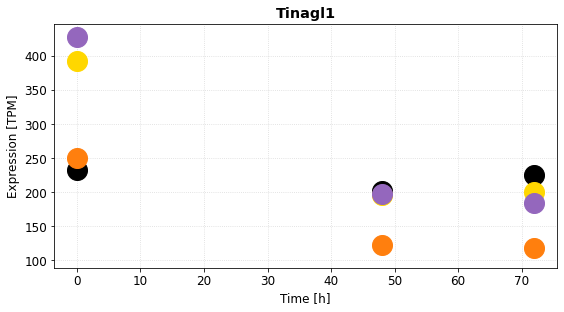

['a3922_0h_1', 'a3922_0h_2', 'a3922_0h_3']
['a3922_48h_1', 'a3922_48h_2', 'a3922_48h_3']
['a3922_72h_1', 'a3922_72h_2', 'a3922_72h_3']
[0, 48, 72]
[419.2406160865233, 483.9641126119024, 461.38544453036167]
['a4774_0h_1', 'a4774_0h_2', 'a4774_0h_3']
['a4774_48h_1', 'a4774_48h_2', 'a4774_48h_3']
['a4774_72h_1', 'a4774_72h_2']
[0, 48, 72]
[487.177498627931, 282.63629583363, 264.37812466891]
['a4775_0h_1', 'a4775_0h_2', 'a4775_0h_3']
['a4775_48h_1', 'a4775_48h_2', 'a4775_48h_3']
['a4775_72h_1', 'a4775_72h_2', 'a4775_72h_3']
[0, 48, 72]
[490.2804989734744, 301.97112589182433, 246.12510859195868]
['a4776_0h_1', 'a4776_0h_2', 'a4776_0h_3']
['a4776_48h_1', 'a4776_48h_2', 'a4776_48h_3']
['a4776_72h_1', 'a4776_72h_2', 'a4776_72h_3']
[0, 48, 72]
[486.3745874281303, 217.84434958108702, 157.494755507327]


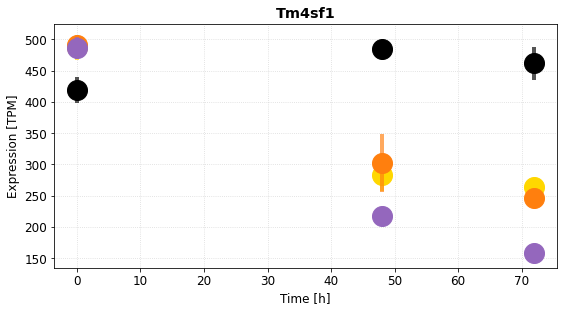

['a3922_0h_1', 'a3922_0h_2', 'a3922_0h_3']
['a3922_48h_1', 'a3922_48h_2', 'a3922_48h_3']
['a3922_72h_1', 'a3922_72h_2', 'a3922_72h_3']
[0, 48, 72]
[7.85633927326887, 14.690889658038232, 9.049750173003664]
['a4774_0h_1', 'a4774_0h_2', 'a4774_0h_3']
['a4774_48h_1', 'a4774_48h_2', 'a4774_48h_3']
['a4774_72h_1', 'a4774_72h_2']
[0, 48, 72]
[18.863371301810968, 6.46196835367023, 5.122889286323205]
['a4775_0h_1', 'a4775_0h_2', 'a4775_0h_3']
['a4775_48h_1', 'a4775_48h_2', 'a4775_48h_3']
['a4775_72h_1', 'a4775_72h_2', 'a4775_72h_3']
[0, 48, 72]
[13.501272662421334, 10.800293644148004, 9.041101353023686]
['a4776_0h_1', 'a4776_0h_2', 'a4776_0h_3']
['a4776_48h_1', 'a4776_48h_2', 'a4776_48h_3']
['a4776_72h_1', 'a4776_72h_2', 'a4776_72h_3']
[0, 48, 72]
[10.035905792731834, 4.196332816705966, 2.5143790791072433]


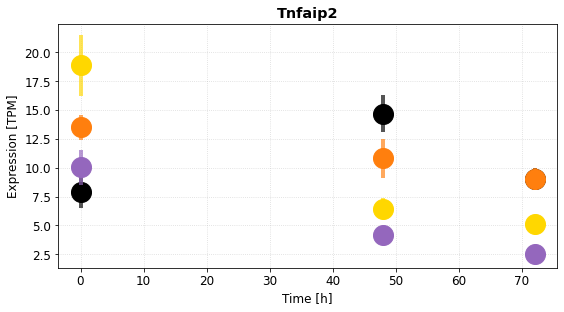

['a3922_0h_1', 'a3922_0h_2', 'a3922_0h_3']
['a3922_48h_1', 'a3922_48h_2', 'a3922_48h_3']
['a3922_72h_1', 'a3922_72h_2', 'a3922_72h_3']
[0, 48, 72]
[1.016319467583157, 0.8581203040247604, 0.7948212695198943]
['a4774_0h_1', 'a4774_0h_2', 'a4774_0h_3']
['a4774_48h_1', 'a4774_48h_2', 'a4774_48h_3']
['a4774_72h_1', 'a4774_72h_2']
[0, 48, 72]
[1.2637545549055833, 3.0606998953368767, 2.53030147831472]
['a4775_0h_1', 'a4775_0h_2', 'a4775_0h_3']
['a4775_48h_1', 'a4775_48h_2', 'a4775_48h_3']
['a4775_72h_1', 'a4775_72h_2', 'a4775_72h_3']
[0, 48, 72]
[0.9232024884211093, 3.01774449000543, 1.9816309918359334]
['a4776_0h_1', 'a4776_0h_2', 'a4776_0h_3']
['a4776_48h_1', 'a4776_48h_2', 'a4776_48h_3']
['a4776_72h_1', 'a4776_72h_2', 'a4776_72h_3']
[0, 48, 72]
[1.8044504790681917, 9.3969523263592, 9.88437868599115]


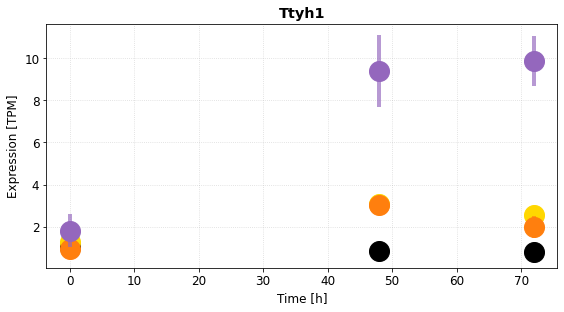

['a3922_0h_1', 'a3922_0h_2', 'a3922_0h_3']
['a3922_48h_1', 'a3922_48h_2', 'a3922_48h_3']
['a3922_72h_1', 'a3922_72h_2', 'a3922_72h_3']
[0, 48, 72]
[19.19310712092117, 15.463782767777433, 19.368865633178434]
['a4774_0h_1', 'a4774_0h_2', 'a4774_0h_3']
['a4774_48h_1', 'a4774_48h_2', 'a4774_48h_3']
['a4774_72h_1', 'a4774_72h_2']
[0, 48, 72]
[12.311416910090133, 23.723585971100203, 28.8088741291448]
['a4775_0h_1', 'a4775_0h_2', 'a4775_0h_3']
['a4775_48h_1', 'a4775_48h_2', 'a4775_48h_3']
['a4775_72h_1', 'a4775_72h_2', 'a4775_72h_3']
[0, 48, 72]
[14.508799778202132, 19.5013990353911, 26.0919985195351]
['a4776_0h_1', 'a4776_0h_2', 'a4776_0h_3']
['a4776_48h_1', 'a4776_48h_2', 'a4776_48h_3']
['a4776_72h_1', 'a4776_72h_2', 'a4776_72h_3']
[0, 48, 72]
[11.1677222069153, 25.77168359830033, 30.25706084560747]


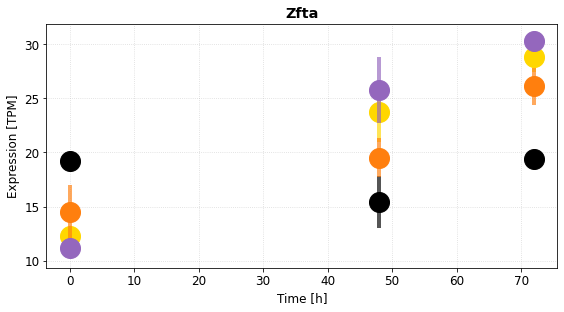

In [28]:
for gene_name in strong_pattern_gene_names:
    ensembl = annotation[annotation['ext_gene'] == gene_name].index.to_list()[0]
    ensembl_trajectory = []; ensembl_times = []
    for mouse in mice:
        plotting_means = []
        plotting_stds = []
        for time in times:
            working_labels = [label for label in expression.columns if mouse in label and time in label]
            print(working_labels)
            values = expression.loc[ensembl, working_labels]
            plotting_means.append(numpy.mean(values))
            plotting_stds.append(numpy.std(values))
            
        # plot data
        if mouse == 'a3922':
            the_color = 'black'
        elif mouse == 'a4774':
            the_color = 'gold'
        elif mouse == 'a4775':
            the_color = 'tab:orange'
        elif mouse == 'a4776':
            the_color = 'tab:purple'
        else:
            print('error')
        print(numerical_times)
        print(plotting_means)
        matplotlib.pyplot.errorbar(numerical_times, plotting_means, yerr=plotting_stds, color=the_color, lw=0, elinewidth=4, alpha=2/3)
        matplotlib.pyplot.plot(numerical_times, plotting_means, 'o', color=the_color, ms=20)
        
        ## plot the regression lines based on mice expresssion
        
    # close figure
    matplotlib.pyplot.grid(alpha=0.5, ls=':')
    matplotlib.pyplot.title(gene_name, fontweight='bold')
    matplotlib.pyplot.xlabel('Time [h]')
    matplotlib.pyplot.ylabel('Expression [TPM]')
    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()

In [29]:
this is the end

SyntaxError: invalid syntax (<ipython-input-29-03663f94ce18>, line 1)

In [ ]:
this is the end


In [ ]:
# appendix. Run the analysis for direct targets. 
# run the overlap with DESeq2
# identify the number of DEGs (filtered) that separate time, biological differences at time zero, and then the ones responding to the mutation. make a pca here, probably in a different notebook

## 3.2. identify the pattern of change in MUT and flat in WT

In [ ]:
t = numpy.array(numerical_times)
wt = simple_expression.loc[ensembl][:3].to_list()
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(t, wt)
fitted_wt = slope*t + intercept
log2_fc_wt = numpy.log2(fitted_wt[-1] / fitted_wt[0])
print(log2_fc_wt)


In [ ]:
over_mice = []
for mouse in mice[1:]:
    print('working with mouse {}'.format(mouse))
    
    ### significance
    path = DEG_folder + mouse + '.t72overt0.LRT.csv'
    df = pandas.read_csv(path, sep=',', index_col='target_id')
    significants = df.index.to_list()
    print('\t significance detected for {} genes'.format(len(significants)))
    
    ### filter out genes that do not cross the abs log2FC >= 1 and the max. expr. >= 2
    substantials = []
    for significant in significants:
        start = mice_expression.loc[significant, '{}_0h'.format(mouse)]
        end = mice_expression.loc[significant, '{}_72h'.format(mouse)]
        abs_log2FC = numpy.abs(numpy.log2((end+1)/(start+1)))
        max_expr = numpy.max([start, end])
        if abs_log2FC >= 1 and max_expr >= 2:
            substantials.append(significant)
    print('\t substantial change found for {} genes'.format(len(substantials)))
    
    ### determine if substantials are flat in WT
    pattern_ensembls = []
    for substantial in substantials:
        if substantial in wt_flat_genes:
            pattern_ensembls.append(substantial)
    print('\t searched pattern found for {} genes'.format(len(pattern_ensembls)))
    
    ### determine if fitted delta between WT and MUT is larger than one
    response_ensembls = []
    mouse_labels = [label for label in mice_expression.columns if mouse in label]
    for ensembl in pattern_ensembls:
        t = numpy.array(numerical_times)
        wt = simple_expression.loc[ensembl][:3].to_list()
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(t, wt)
        fitted_wt = numpy.round(slope*t + intercept, 0)
        fitted_wt[fitted_wt < 0] = 0
        log2_fc_wt = numpy.log2((fitted_wt[-1]+1) / (fitted_wt[0]+1))  
    
        mut = mice_expression.loc[ensembl, mouse_labels].to_list()
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(t, mut)
        fitted_mut = numpy.round(slope*t + intercept, 0)
        fitted_mut[fitted_mut < 0] = 0
        log2_fc_mut = numpy.log2((fitted_mut[-1]+1) / (fitted_mut[0]+1))
        
        delta = log2_fc_mut - log2_fc_wt
        if numpy.abs(delta) >= 1:
            response_ensembls.append(ensembl)
    print('\t response found for {} genes'.format(len(response_ensembls)))
        
    ### add the final set of response genes to find the intersect
    over_mice.append(set(response_ensembls))
        
    print()
    
induced = list(over_mice[0] & over_mice[1] & over_mice[2])
print('induced genes: {}'.format(len(induced)))

In [ ]:
this is the end

# 4. plot and print identified genes

## 4.1. print selected set of genes

### Enrichment

Mus musculus (REF)	upload_1 ( Hierarchy  NEW! Tips)
Reactome pathways	#	#	expected	Fold Enrichment	+/-	P value
HS-GAG degradation	22	3	.03	> 100	+	6.89E-03

Naglu, Gpc2, Hpse

In [ ]:
index = 0
for ensembl in response_genes:
    index = index + 1
    gene_name = annotation.loc[ensembl]['ext_gene']
    description = annotation.loc[ensembl]['description'].split(' [')[0]
    if simple_expression.loc[ensembl, 'MUT_72h'] > simple_expression.loc[ensembl, 'MUT_0h']:
        trend = 'up'
        message = '\t'.join([str(index), ensembl, gene_name, trend, description])
        print(termcolor.colored(message, 'red'))
    else:
        trend = 'down'
        message = '\t'.join([str(index), ensembl, gene_name, trend, description])
        print(termcolor.colored(message, 'blue'))

In [ ]:
# comparison with DESeq2 relax. It should be 27 genes.
list_deseq2 = ['ENSMUSG00000001751', 'ENSMUSG00000003617', 'ENSMUSG00000009687', 'ENSMUSG00000013653', 'ENSMUSG00000014444', 'ENSMUSG00000016496', 'ENSMUSG00000017817', 'ENSMUSG00000021998', 'ENSMUSG00000022243', 'ENSMUSG00000023009', 'ENSMUSG00000026857', 'ENSMUSG00000028194', 'ENSMUSG00000028713', 'ENSMUSG00000029510', 'ENSMUSG00000029661', 'ENSMUSG00000029861', 'ENSMUSG00000030796', 'ENSMUSG00000035273', 'ENSMUSG00000036853', 'ENSMUSG00000041828', 'ENSMUSG00000046727', 'ENSMUSG00000047793', 'ENSMUSG00000047797', 'ENSMUSG00000059013', 'ENSMUSG00000068220', 'ENSMUSG00000074892', 'ENSMUSG00000074968']
print(len(list_deseq2))

In [ ]:
print('sleuth-specific DEGs:')
index = 0
for ensembl in response_genes:
    if ensembl not in list_deseq2:
        index = index + 1
        gene_name = annotation.loc[ensembl]['ext_gene']
        description = annotation.loc[ensembl]['description'].split(' [')[0] 
        message = '\t'.join([str(index), ensembl, gene_name, description])
        print(message)

print()

print('DESeq2-specific DEGs:')
index = 0
for ensembl in list_deseq2:
    if ensembl not in list_five:
        index = index + 1
        gene_name = annotation.loc[ensembl]['ext_gene']
        description = annotation.loc[ensembl]['description'].split(' [')[0] 
        message = '\t'.join([str(index), ensembl, gene_name, description])
        print(message)
        
print()

print('Common in both')
common = list(set(response_genes) & set(list_deseq2))
index = 0
for ensembl in common:
    index = index + 1
    gene_name = annotation.loc[ensembl]['ext_gene']
    description = annotation.loc[ensembl]['description'].split(' [')[0] 
    message = '\t'.join([str(index), ensembl, gene_name, description])
    print(message)

## 4.2. generate trajectory plots

In [ ]:
matplotlib.rcParams.update({'figure.figsize':(16/3, 9/3)})
matplotlib.rcParams.update({'font.size':10, 'xtick.labelsize':8, 'ytick.labelsize':8, 'figure.figsize':(16/3, 9/3), 'axes.labelsize':10})

expression_labels = expression.columns
wt_labels = [label for label in simple_expression.columns if 'WT' in label]
mut_labels = [label for label in simple_expression.columns if 'MUT' in label]
fitted_change_dict = {}

list_six = [annotation.loc[ensembl]['ext_gene'] for ensembl in list_five]
list_six.sort()

for ensembl in response_genes:
    gene_name = annotation.loc[ensembl]['ext_gene']
    ensembl_trajectory = []; ensembl_times = []
    fitted_change_dict[gene_name] = []
    
    for mouse in mice:
        plotting_means = []
        plotting_stds = []
        
        for time in times:
            working_labels = [label for label in expression_labels if mouse in label and time in label]
            values = expression.loc[ensembl, working_labels]
            plotting_means.append(numpy.mean(values))
            plotting_stds.append(numpy.std(values))
            
            for value in values.to_list():
                ensembl_trajectory.append(value)
                ensembl_times.append(int(time.split('h')[0]))
            
        # plot data
        if mouse == 'a3922':
            the_color = 'black'
        elif mouse == 'a4774':
            the_color = 'gold'
        elif mouse == 'a4775':
            the_color = 'tab:orange'
        elif mouse == 'a4776':
            the_color = 'tab:purple'
        else:
            print('error')
        matplotlib.pyplot.errorbar(numerical_times, plotting_means, yerr=plotting_stds, color=the_color, lw=0, elinewidth=4, alpha=2/3)
        matplotlib.pyplot.plot(numerical_times, plotting_means, 'o', color=the_color, ms=20)
            
    # fit and visualize trend
    x = ensembl_times[:9]
    y = ensembl_trajectory[:9]
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    newx = numpy.arange(0, 72+1, 1)
    newy = slope*newx + intercept
    matplotlib.pyplot.plot(newx, newy, '-', color='black', lw=5, zorder=0)
    # store info for z-score heatmap
    d = slope*numpy.array(numerical_times) + intercept
    for element in d:
        fitted_change_dict[gene_name].append(element)
    
    x = ensembl_times[9:]
    y = ensembl_trajectory[9:]
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    newx = numpy.arange(0, 72+1, 1)
    newy = slope*newx + intercept
    matplotlib.pyplot.plot(newx, newy, '-', color='tab:red', lw=5, zorder=0)
    
    # store info for z-score heatmap
    d = slope*numpy.array(numerical_times) + intercept
    for element in d:
        fitted_change_dict[gene_name].append(element)
        
    # define legend elements
    legend_elements = [
        matplotlib.lines.Line2D([0], [0], color='white', marker='o', markeredgecolor='white', markerfacecolor='gold', markersize=25),
        matplotlib.lines.Line2D([0], [0], color='white', marker='o', markeredgecolor='white', markerfacecolor='tab:orange', markersize=25),
        matplotlib.lines.Line2D([0], [0], color='white', marker='o', markeredgecolor='white', markerfacecolor='tab:purple', markersize=25),
        
        matplotlib.lines.Line2D([0], [0], color='black', ls='-', lw=5),
        matplotlib.lines.Line2D([0], [0], color='tab:red', ls='-', lw=5)      
]
    matplotlib.pyplot.legend(legend_elements, ['Mut A', 'Mut B', 'Mut C', 'WT', 'MUT'], ncol=2)
    
    # close figure
    matplotlib.pyplot.grid(alpha=0.5, ls=':')
    matplotlib.pyplot.title(gene_name, fontweight='bold')
    matplotlib.pyplot.xlabel('Time [h]')
    matplotlib.pyplot.ylabel('Expression [TPM]')
    matplotlib.pyplot.tight_layout()
    #matplotlib.pyplot.show()

## 4.3. generate heatmap on z-score

In [ ]:
df = pandas.DataFrame(fitted_change_dict)
tdf = df.transpose()
tdf.columns = simple_expression.columns
tdf.head()

In [ ]:
# retrieve x and y for volcano plot
volcanox = []; volcanoy = []
for gene_name in tdf.index:
    average_expression = numpy.mean(numpy.log10(tdf.loc[gene_name, :]))
    fc_wt = (tdf.loc[gene_name, 'WT_72h']+1) / (tdf.loc[gene_name, 'WT_0h']+1)
    fc_mut = (tdf.loc[gene_name, 'MUT_72h']+1) / (tdf.loc[gene_name, 'MUT_0h']+1)
    delta = numpy.log2(fc_mut) - numpy.log2(fc_wt)
    volcanox.append(delta); volcanoy.append(average_expression)

In [ ]:
rounded_df = numpy.round(tdf, 0) + 1
rounded_df.head()

In [ ]:
zscore_df = scipy.stats.zscore(rounded_df, axis=1)
zscore_df.head()

In [ ]:
zscore_df = zscore_df[['MUT_0h', 'MUT_48h', 'MUT_72h','WT_0h', 'WT_48h', 'WT_72h']]
zscore_df.head()

In [ ]:
print(numpy.max(zscore_df.max()))
print(numpy.min(zscore_df.min()))

top = 2.5; bottom = -2.5
top_white = 5/6; bottom_white = -5/6

In [ ]:
# edited from https://stackoverflow.com/questions/59270751/how-to-make-a-diverging-color-bar-with-white-space-between-two-values-matplotlib
p = [bottom, bottom_white, top_white, top]
f = lambda x: numpy.interp(x, p, [0, 0.5, 0.5, 1])
new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('map_white', list(zip(numpy.linspace(0,1), matplotlib.pyplot.cm.bwr(f(numpy.linspace(min(p), max(p)))))))

In [ ]:
linkage_method = 'ward'
distance_metric = 'euclidean'
seaborn.set(font_scale=0.9)

h = seaborn.clustermap(zscore_df, cmap=new_cmap, col_cluster=False, vmin=bottom, vmax=top, method=linkage_method, metric=distance_metric, yticklabels=1, xticklabels = ['MUT 0h', 'MUT 48h', 'MUT 72h', 'WT 0h', 'WT 48h', 'WT 72h'], cbar_kws={'label':'Expression (z-score)'})

ordered_gene_names = [element.get_text() for element in h.ax_heatmap.get_yticklabels()]
for gene_name in ordered_gene_names:
    print(gene_name)

matplotlib.pyplot.title('{} {}'.format(linkage_method, distance_metric))
matplotlib.pyplot.tight_layout()

#matplotlib.pyplot.show()

matplotlib.pyplot.savefig('heatmap.svg')

In [ ]:
# just a different visualization of the same data
linkage_method = 'ward'
distance_metric = 'euclidean'
seaborn.set(font_scale=0.9)

seaborn.clustermap(zscore_df, cmap='RdBu_r', col_cluster=False, vmin=bottom, vmax=top, method=linkage_method, metric=distance_metric, yticklabels=1, xticklabels = ['MUT 0h', 'MUT 48h', 'MUT 72h', 'WT 0h', 'WT 48h', 'WT 72h'], cbar_kws={'label':'Expression (z-score)'})

matplotlib.pyplot.title('{} {}'.format(linkage_method, distance_metric))
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [ ]:
seaborn.reset_orig()
matplotlib.rcParams.update({'font.size':20, 'font.family':'sans-serif', 'xtick.labelsize':30, 'ytick.labelsize':30, 'figure.figsize':(16, 9), 'axes.labelsize':40})

## 4.4. pseudo volcano plot

In [ ]:
gene_names = rounded_df.index

for i in range(len(volcanox)):
    
    if -1 <= volcanox[i] <= 1:
        the_color = 'gray'
        matplotlib.pyplot.text(volcanox[i], volcanoy[i]+(3.5/25), gene_names[i], color=the_color)
    elif volcanox[i] > 1:
        the_color = 'tab:red'
        matplotlib.pyplot.text(volcanox[i]+(7/50), volcanoy[i]+(3.5/25), gene_names[i], color=the_color)
    elif volcanox[i] < -1:
        the_color = 'tab:blue'
        matplotlib.pyplot.text(volcanox[i]-(7/12), volcanoy[i]+(3.5/25), gene_names[i], color=the_color)
    else:
        print(volcanox[i])
        print('error')
        
    # finally plotting the dot
    matplotlib.pyplot.scatter(volcanox[i], volcanoy[i], s=1000, c=the_color, alpha=2/3, edgecolor='none')
    
    # printing for interpretation
    if the_color == 'tab:blue':
        printing_color = 'blue'
    elif the_color == 'tab:red':
        printing_color = 'red'
    else:
        printing_color = 'grey'
    message = '\t'.join([str(i+1), gene_names[i], '{:.3f}'.format(volcanox[i]), '{:.3f}'.format(volcanoy[i]), the_color])
    print(termcolor.colored(message, printing_color))

matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xlabel('Differential response\n[log$_2$FC$^{MUT}$(T72/T0) -  log$_2$FC$^{WT}$(T72/T0)]')
matplotlib.pyplot.ylabel('Average expression\n[log$_{10}$ TPM]')
matplotlib.pyplot.axvline(1, color='gray', ls='--', lw=3, zorder=0)
matplotlib.pyplot.axvline(-1, color='gray', ls='--', lw=3, zorder=0)
matplotlib.pyplot.xlim([-5, 5])
matplotlib.pyplot.ylim([0, 3.5])
matplotlib.pyplot.tight_layout()

# 5. Mitf direct targets analysis

## 5.1. read Dorothea database

In [ ]:
dorothea = pandas.read_csv(dorothea_file, sep='\t', index_col=0)
print(dorothea.shape)
dorothea.head()

In [ ]:
# define gene names for annotation
annotation_gene_names = set(annotation['ext_gene'].to_list())
print('annotation genes: {}'.format(len(annotation_gene_names)))

a = set(dorothea['tf'].to_list())
b = set(dorothea['target'].to_list())
dorothea_genes = a.union(b)
print('dorothea genes: {}'.format(len(dorothea_genes)))


universe = list(annotation_gene_names & dorothea_genes)
print('common universe genes: {}'.format(len(universe)))

## 5.2. define the set of Mitf direct targets

In [ ]:
direct_targets = dorothea[dorothea['tf'] == 'Mitf']
print(direct_targets.shape)
direct_targets.head()

In [ ]:
direct_targets_names = direct_targets['target'].to_list()
print(len(direct_targets_names))

## 5.3. define the number of responding genes among Mitf direct target genes

In [ ]:
print(direct_targets_names, len(direct_targets_names))
response_genes = gene_names.to_list()
print(response_genes, len(response_genes))

In [ ]:
successes = list(set(direct_targets_names) & set(response_genes))
print(successes)

## 5.4. plot the behaviour of the Mitf direct target genes

In [ ]:
list_seven = []
for gene_name in direct_targets_names:
    ensembl = annotation[annotation['ext_gene'] == gene_name].index.to_list()[0]
    list_seven.append(ensembl)
print(len(list_seven))

In [ ]:
matplotlib.rcParams.update({'figure.figsize':(16/3, 9/3)})
matplotlib.rcParams.update({'font.size':10, 'xtick.labelsize':8, 'ytick.labelsize':8, 'figure.figsize':(16/3, 9/3), 'axes.labelsize':10})

expression_labels = expression.columns
wt_labels = [label for label in simple_expression.columns if 'WT' in label]
mut_labels = [label for label in simple_expression.columns if 'MUT' in label]
fitted_change_dict = {}

for ensembl in list_seven:
    gene_name = annotation.loc[ensembl]['ext_gene']
    ensembl_trajectory = []; ensembl_times = []
    fitted_change_dict[gene_name] = []
    
    for mouse in mice:
        plotting_means = []
        plotting_stds = []
        
        for time in times:
            working_labels = [label for label in expression_labels if mouse in label and time in label]
            values = expression.loc[ensembl, working_labels]
            plotting_means.append(numpy.mean(values))
            plotting_stds.append(numpy.std(values))
            
            for value in values.to_list():
                ensembl_trajectory.append(value)
                ensembl_times.append(int(time.split('h')[0]))
            
        # plot data
        if mouse == 'a3922':
            the_color = 'black'
        elif mouse == 'a4774':
            the_color = 'gold'
        elif mouse == 'a4775':
            the_color = 'tab:orange'
        elif mouse == 'a4776':
            the_color = 'tab:purple'
        else:
            print('error')
        matplotlib.pyplot.errorbar(numerical_times, plotting_means, yerr=plotting_stds, color=the_color, lw=0, elinewidth=4, alpha=2/3)
        matplotlib.pyplot.plot(numerical_times, plotting_means, 'o', color=the_color, ms=20)
            
    # fit and visualize trend
    x = ensembl_times[:9]
    y = ensembl_trajectory[:9]
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    newx = numpy.arange(0, 72+1, 1)
    newy = slope*newx + intercept
    matplotlib.pyplot.plot(newx, newy, '-', color='black', lw=5, zorder=0)
    # store info for z-score heatmap
    d = slope*numpy.array(numerical_times) + intercept
    for element in d:
        fitted_change_dict[gene_name].append(element)
    
    x = ensembl_times[9:]
    y = ensembl_trajectory[9:]
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    newx = numpy.arange(0, 72+1, 1)
    newy = slope*newx + intercept
    matplotlib.pyplot.plot(newx, newy, '-', color='tab:red', lw=5, zorder=0)
    
    # store info for z-score heatmap
    d = slope*numpy.array(numerical_times) + intercept
    for element in d:
        fitted_change_dict[gene_name].append(element)
        
    # define legend elements
    legend_elements = [
        matplotlib.lines.Line2D([0], [0], color='white', marker='o', markeredgecolor='white', markerfacecolor='gold', markersize=25),
        matplotlib.lines.Line2D([0], [0], color='white', marker='o', markeredgecolor='white', markerfacecolor='tab:orange', markersize=25),
        matplotlib.lines.Line2D([0], [0], color='white', marker='o', markeredgecolor='white', markerfacecolor='tab:purple', markersize=25),
        
        matplotlib.lines.Line2D([0], [0], color='black', ls='-', lw=5),
        matplotlib.lines.Line2D([0], [0], color='tab:red', ls='-', lw=5)      
]
    matplotlib.pyplot.legend(legend_elements, ['Mut A', 'Mut B', 'Mut C', 'WT', 'MUT'], ncol=2)
    
    # close figure
    matplotlib.pyplot.grid(alpha=0.5, ls=':')
    matplotlib.pyplot.title(gene_name)
    matplotlib.pyplot.xlabel('Time [h]')
    matplotlib.pyplot.ylabel('Expression [TPM]')
    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()

## 5.5. build a heatmap of direct targets

In [ ]:
df = simple_expression.loc[list_seven, :]

new_index = {}
for ensembl in list_seven:
    gene_name = annotation.loc[ensembl]['ext_gene']
    new_index[ensembl] = gene_name
df.rename(index=new_index, inplace=True)

print(df.shape)
df.head()

In [ ]:
# retrieve x and y for volcano plot
volcanox = []; volcanoy = []
for gene_name in df.index:
    average_expression = numpy.mean(numpy.log10(df.loc[gene_name, :]))
    fc_wt = (df.loc[gene_name, 'WT_72h']+1) / (df.loc[gene_name, 'WT_0h']+1)
    fc_mut = (df.loc[gene_name, 'MUT_72h']+1) / (df.loc[gene_name, 'MUT_0h']+1)
    delta = numpy.log2(fc_mut) - numpy.log2(fc_wt)
    volcanox.append(delta); volcanoy.append(average_expression)

In [ ]:
rounded_df = numpy.round(df, 0) + 1
rounded_df.head()

In [ ]:
zscore_df = scipy.stats.zscore(rounded_df, axis=1)
zscore_df.head()

In [ ]:
zscore_df.fillna(0, inplace=True)
zscore_df.head()

In [ ]:
zscore_df = zscore_df[['MUT_0h', 'MUT_48h', 'MUT_72h','WT_0h', 'WT_48h', 'WT_72h']]
zscore_df.head()

In [ ]:
print(numpy.max(zscore_df.max()))
print(numpy.min(zscore_df.min()))

top = 2.5; bottom = -2.5
top_white = 5/6; bottom_white = -5/6

In [ ]:
# edited from https://stackoverflow.com/questions/59270751/how-to-make-a-diverging-color-bar-with-white-space-between-two-values-matplotlib
p = [bottom, bottom_white, top_white, top]
f = lambda x: numpy.interp(x, p, [0, 0.5, 0.5, 1])
new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('map_white', list(zip(numpy.linspace(0,1), matplotlib.pyplot.cm.bwr(f(numpy.linspace(min(p), max(p)))))))

In [ ]:
linkage_method = 'ward'
distance_metric = 'euclidean'
seaborn.set(font_scale=0.9)

seaborn.clustermap(zscore_df, cmap=new_cmap, col_cluster=False, vmin=bottom, vmax=top, method=linkage_method, metric=distance_metric, yticklabels=1, xticklabels = ['MUT 0h', 'MUT 48h', 'MUT 72h', 'WT 0h', 'WT 48h', 'WT 72h'], cbar_kws={'label':'Expression (z-score)'})

matplotlib.pyplot.title('{} {}'.format(linkage_method, distance_metric))
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [ ]:
seaborn.reset_orig()
matplotlib.rcParams.update({'font.size':20, 'font.family':'sans-serif', 'xtick.labelsize':30, 'ytick.labelsize':30, 'figure.figsize':(16, 9), 'axes.labelsize':40})

# 5.6. pseudo volcano plot

In [ ]:
gene_names = rounded_df.index

for i in range(len(volcanox)):
    
    if -1 <= volcanox[i] <= 1:
        the_color = 'gray'
        matplotlib.pyplot.text(volcanox[i], volcanoy[i]+(11.5/60), gene_names[i], color=the_color)
    elif volcanox[i] > 1:
        the_color = 'tab:red'
        matplotlib.pyplot.text(volcanox[i]+(11/60), volcanoy[i]+(11.5/60), gene_names[i], color=the_colorweak_pattern_genes)
    elif volcanox[i] < -1:
        the_color = 'tab:blue'
        matplotlib.pyplot.text(volcanox[i]-(11/12), volcanoy[i]+(11.5/60), gene_names[i], color=the_color)
    else:
        print(volcanox[i])
        print('error')
        
    # finally plotting the dot
    matplotlib.pyplot.scatter(volcanox[i], volcanoy[i], s=1000, c=the_color, alpha=2/3, edgecolor='none')
    
    # printing for interpretation
    if the_color == 'tab:blue':
        printing_color = 'blue'
    elif the_color == 'tab:red':
        printing_color = 'red'
    else:
        printing_color = 'grey'
    message = '\t'.join([gene_names[i], '{:.3f}'.format(volcanox[i]), '{:.3f}'.format(volcanoy[i]), the_color])
    print(termcolor.colored(message, printing_color))

matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xlabel('Differential response\n[log$_2$FC$^{MUT}$(T72/T0) -  log$_2$FC$^{WT}$(T72/T0)]')
matplotlib.pyplot.ylabel('Average expression\n[log$_{10}$ TPM]')
matplotlib.pyplot.axvline(1, color='gray', ls='--', lw=3, zorder=0)
matplotlib.pyplot.axvline(-1, color='gray', ls='--', lw=3, zorder=0)
matplotlib.pyplot.xlim([-2.5, 2.5])
matplotlib.pyplot.ylim([0, 4.5])
matplotlib.pyplot.tight_layout()